## 0. Data Import

In [1]:
#uncomment to download required packages
#!pip install -r requirements.txt


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import scipy.stats as stats
from arch import arch_model
%config InlineBackend.figure_format = 'retina'

In [3]:
tesla_df = pd.read_csv('QRM-2025-cw2-data.csv')
tesla_df['Date'] = pd.to_datetime(tesla_df['Date'])
#compute the log returns
tesla_df['log_returns'] = np.log(tesla_df.TSLA.shift(1)) - np.log(tesla_df.TSLA)
tesla_df['loss'] = -tesla_df.log_returns

In [4]:
tesla_df.head()

,Date,TSLA,log_returns,loss
0,2012-11-26,2.151333,NaN,NaN
1,2012-11-27,2.143333,0.003726,-0.003726
2,2012-11-28,2.215333,-0.033041,0.033041
3,2012-11-29,2.246000,-0.013748,0.013748
4,2012-11-30,2.254667,-0.003851,0.003851


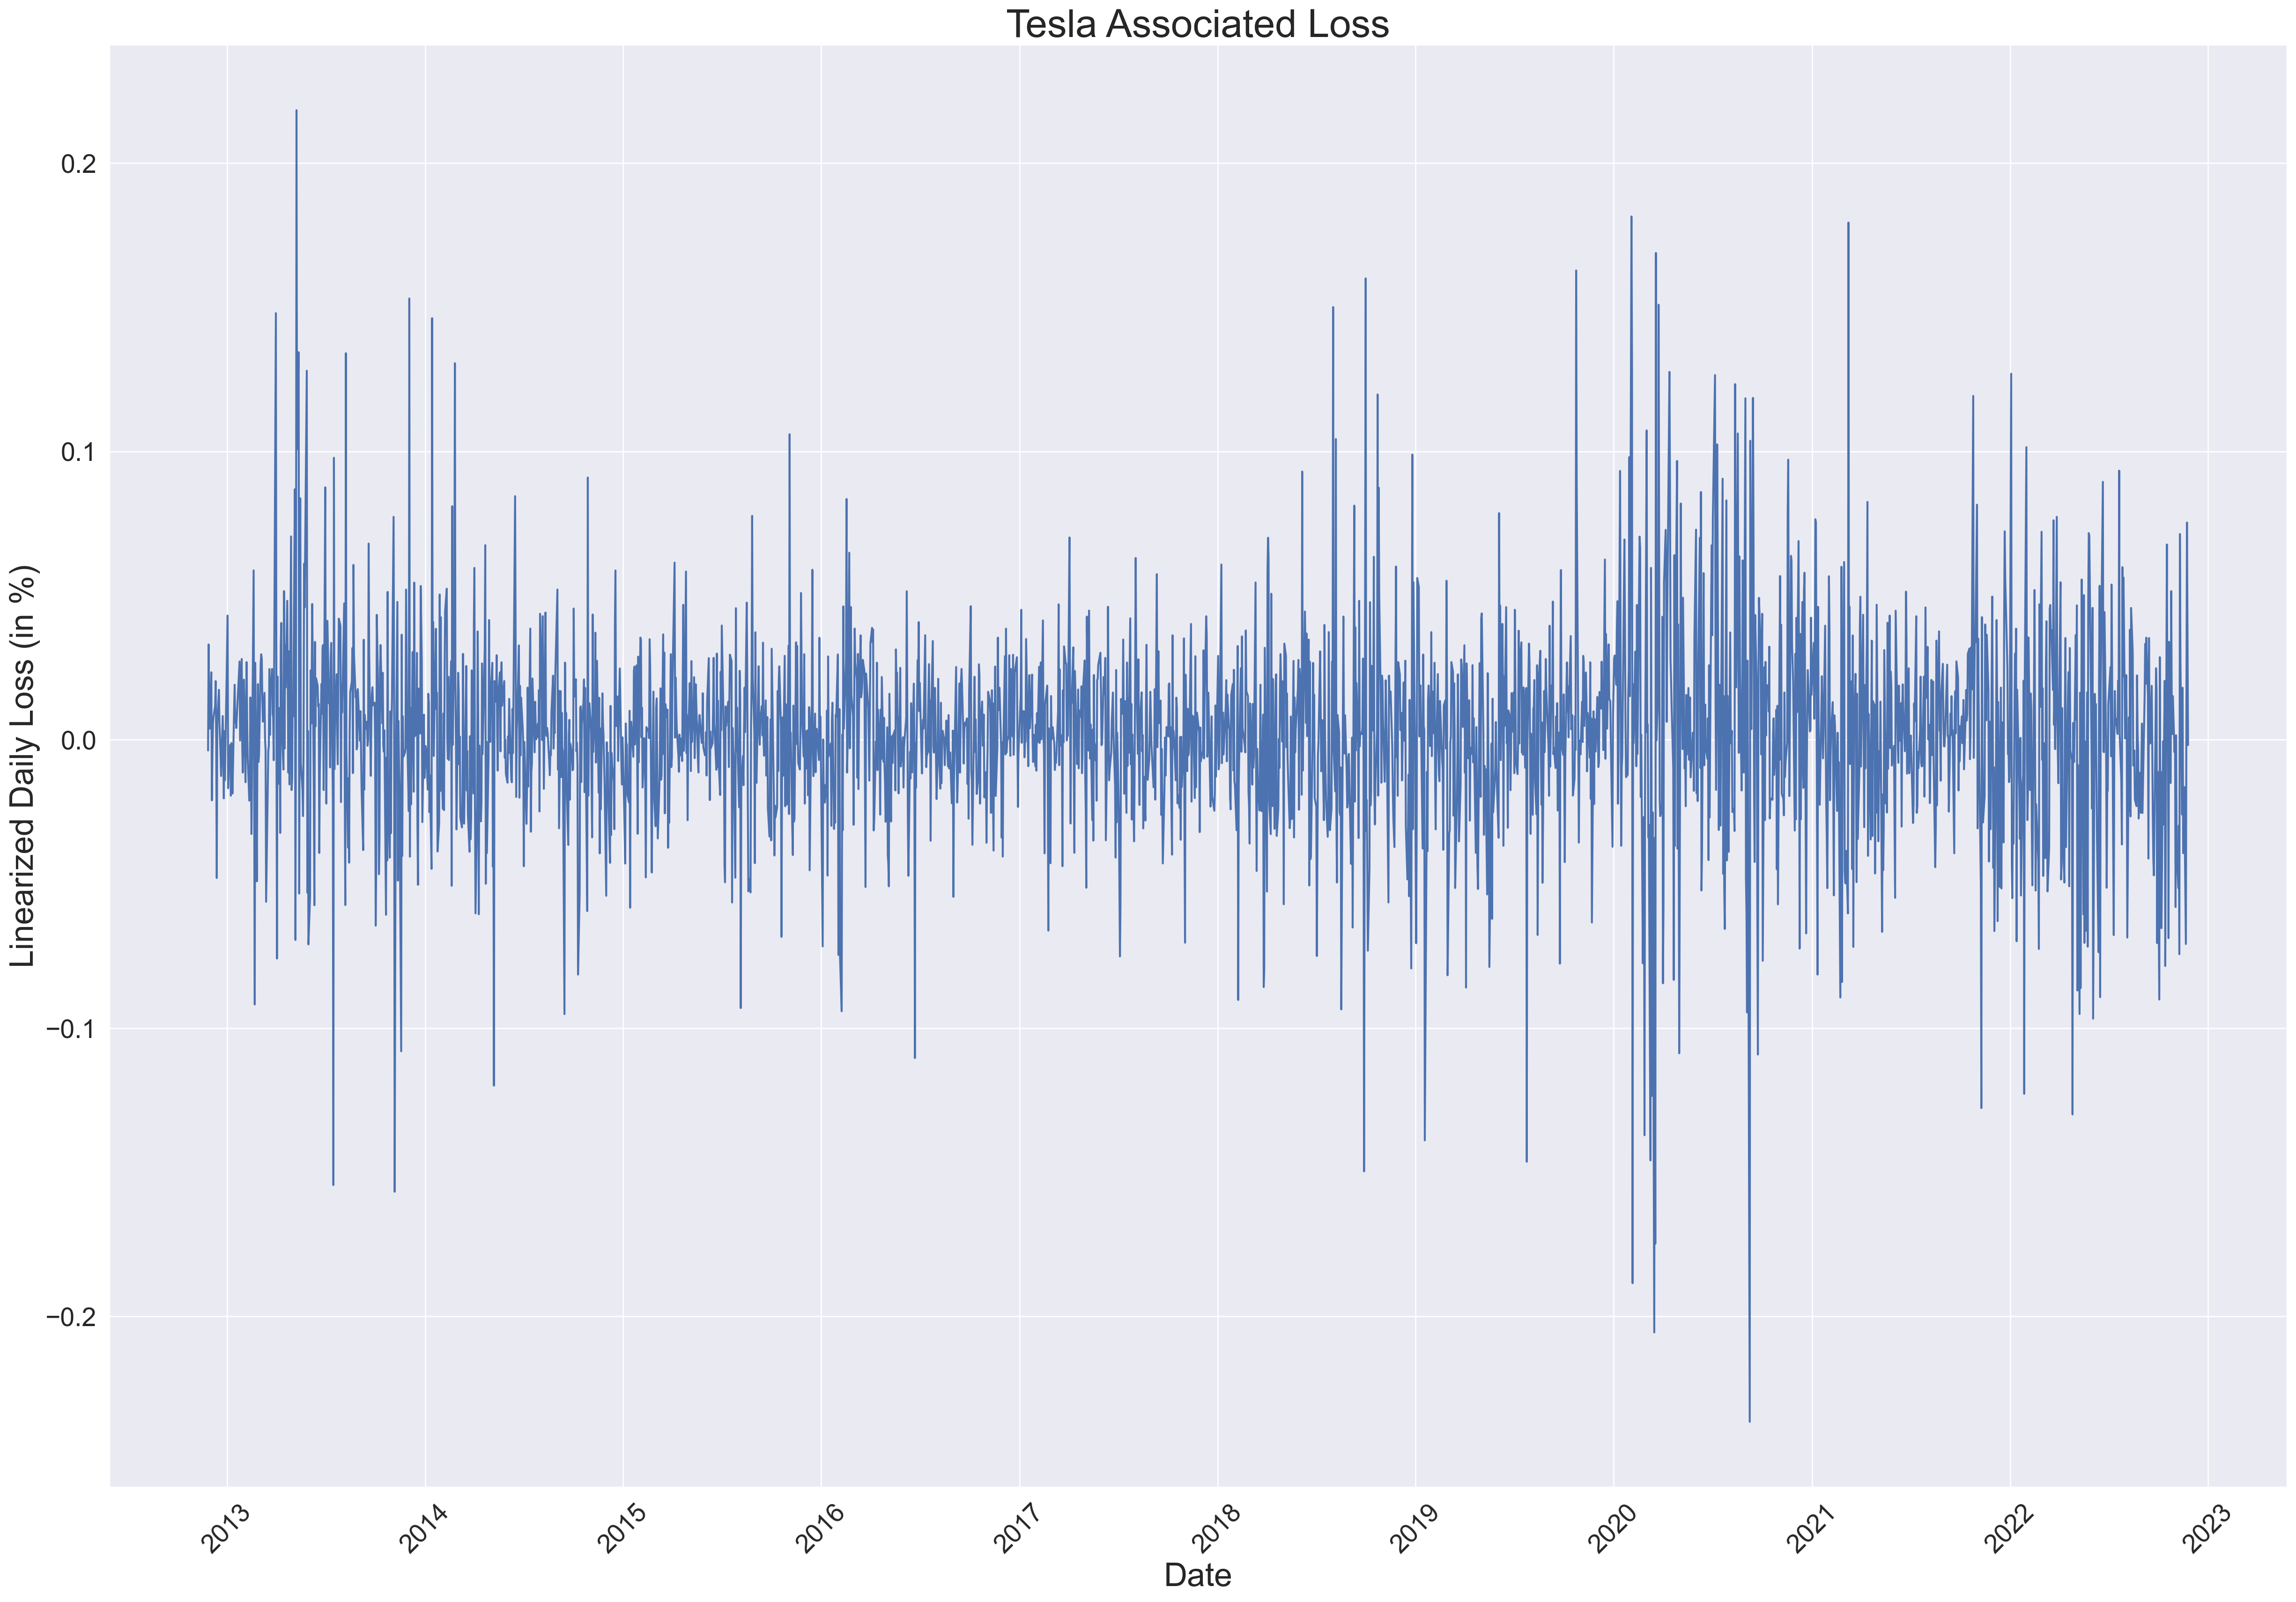

In [5]:
sns.set_theme()
plt.figure(figsize=(30, 20))
sns.lineplot(data=tesla_df, x='Date', y='loss', )
ax = plt.gca()
locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)
ax.tick_params(axis='x', labelsize=20, labelrotation=45) # Pour l'axe X, avec une rotation
ax.tick_params(axis='y', labelsize=20) # Pour l'axe Y
plt.title("Tesla Associated Loss", fontsize=30)
plt.ylabel("Linearized Daily Loss (in %)", fontsize=25)
plt.xlabel("Date", fontsize=25)

plt.show()

--- 
## 1. Modeling on Training Data only 

In [33]:
train_df = tesla_df.loc[tesla_df.Date<'2021-11-26',:].dropna()
test_df = tesla_df.loc[tesla_df.Date>'2021-11-26',:].dropna()

### Fit a GARCH(1,1) model to the loss

In [7]:
GARCH = arch_model(train_df['loss'], mean='Constant', vol='GARCH', p=1, q=1, dist='normal')
res = GARCH.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1079304055.5770965
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2411264586.2126827
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4578.601622614128
            Iterations: 2
            Function evaluations: 26
            Gradient evaluations: 2


c:\Users\ilias\anaconda3\envs\qrm\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001215. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


In [8]:
res

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   loss   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4578.60
Distribution:                  Normal   AIC:                          -9149.20
Method:            Maximum Likelihood   BIC:                          -9126.30
                                        No. Observations:                 2266
Date:                Mon, Dec 01 2025   Df Residuals:                     2265
Time:                        17:24:04   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.5960e-03  6.420e-04      2.486  1.292e-02 [3.

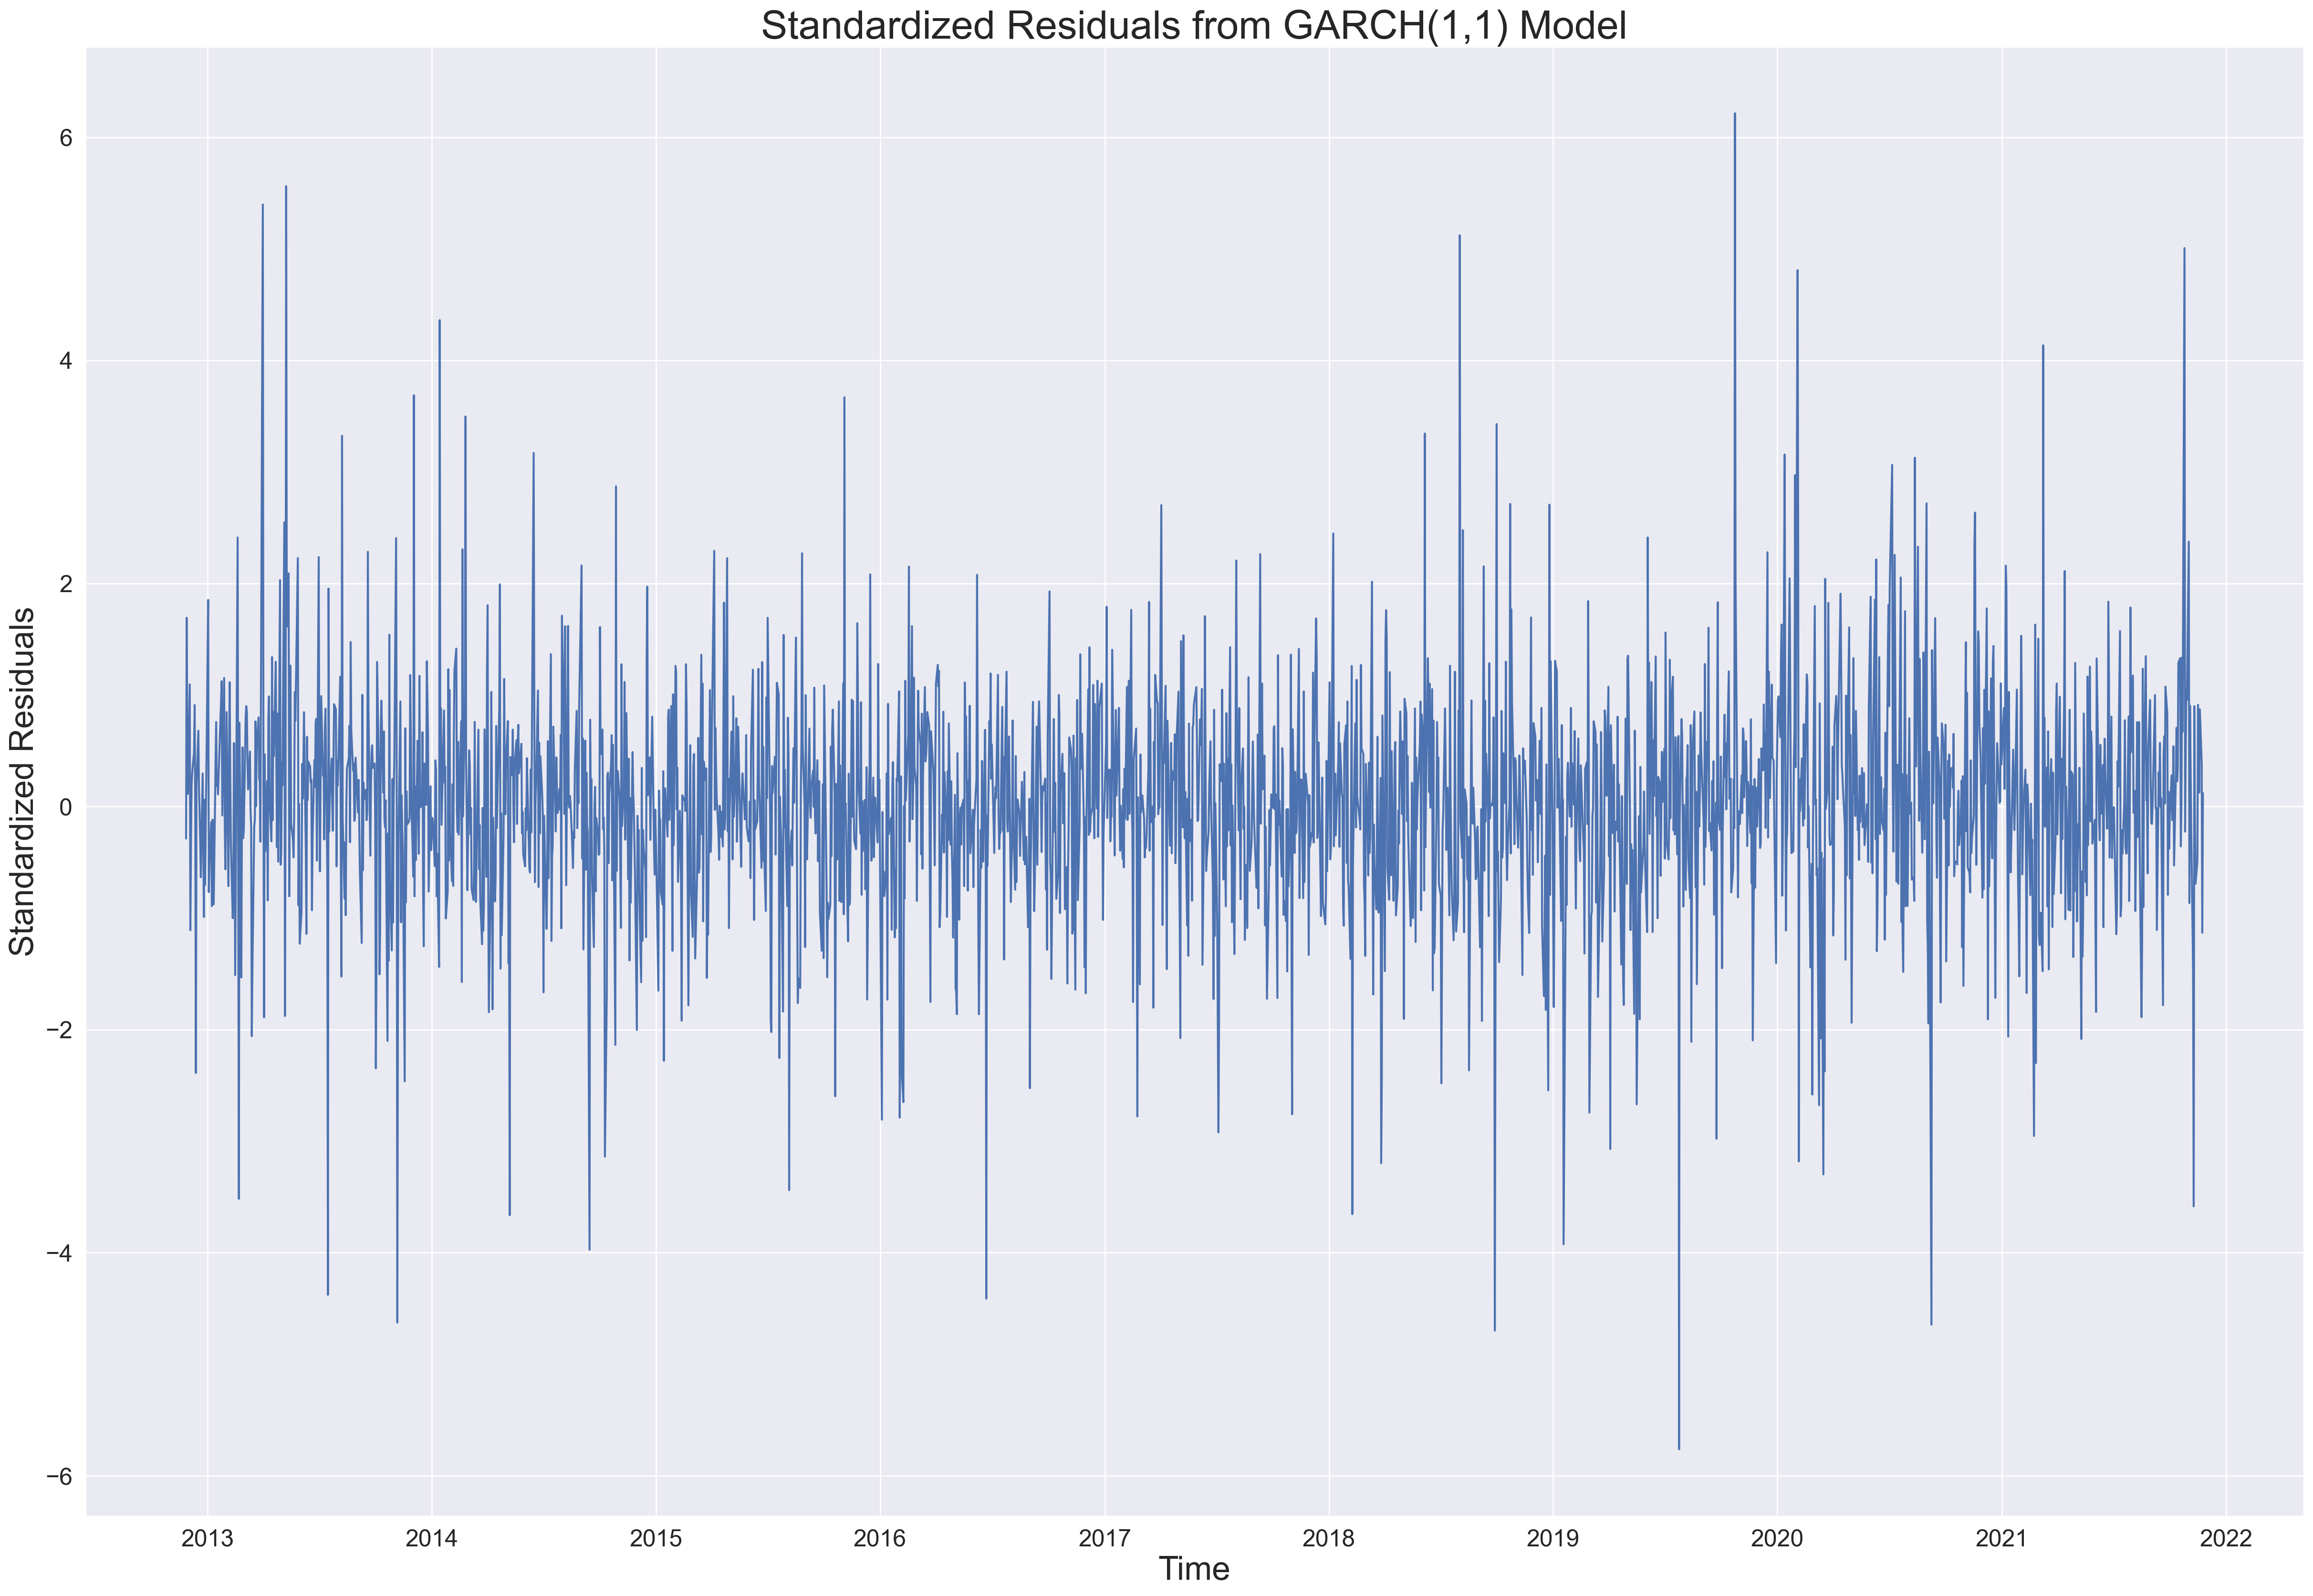

In [51]:
standardized_resid = res.resid/res.conditional_volatility

plt.figure(figsize=(30, 20))
sns.lineplot(x=train_df.Date, y=standardized_resid)
plt.title("Standardized Residuals from GARCH(1,1) Model", fontsize=30)
plt.ylabel("Standardized Residuals", fontsize=25)
plt.xlabel("Time", fontsize=25)
locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

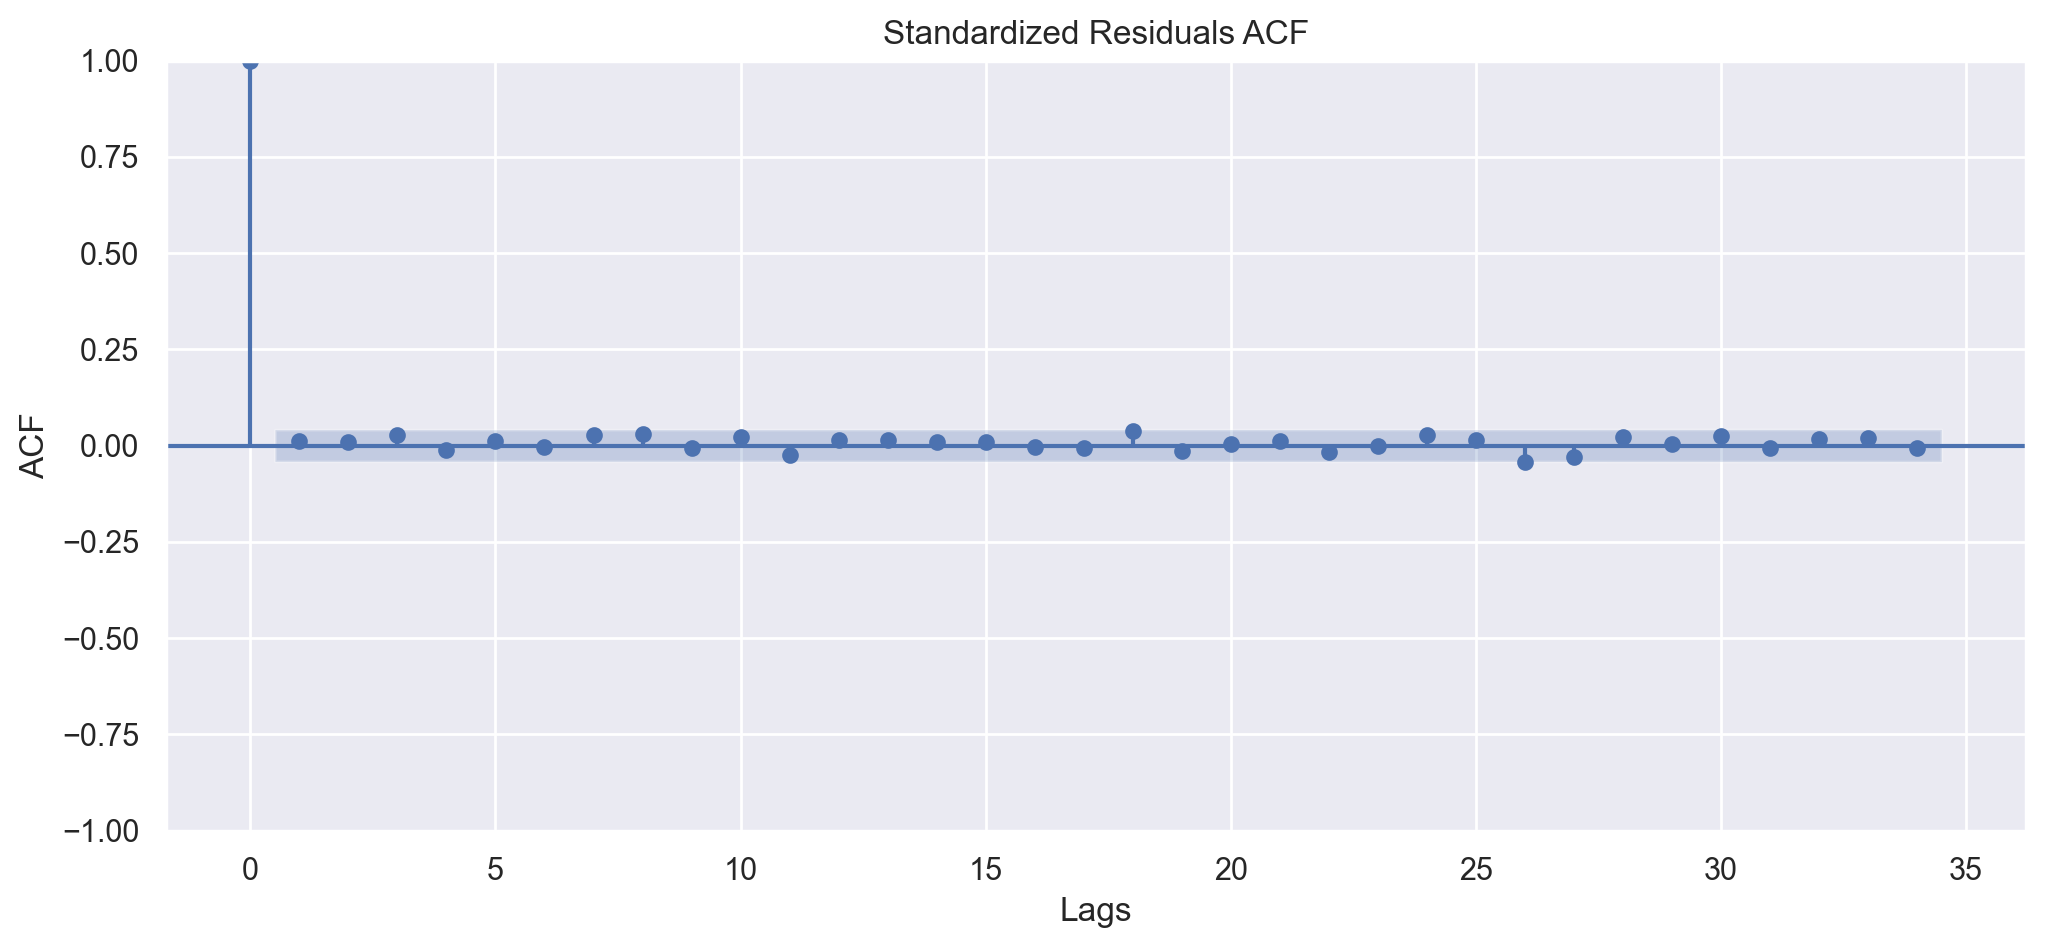

In [10]:
fig, ax = plt.subplots(figsize=(12, 5))

sm.graphics.tsa.plot_acf(standardized_resid, ax=ax)
ax.set_title("Standardized Residuals ACF")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")

plt.show()

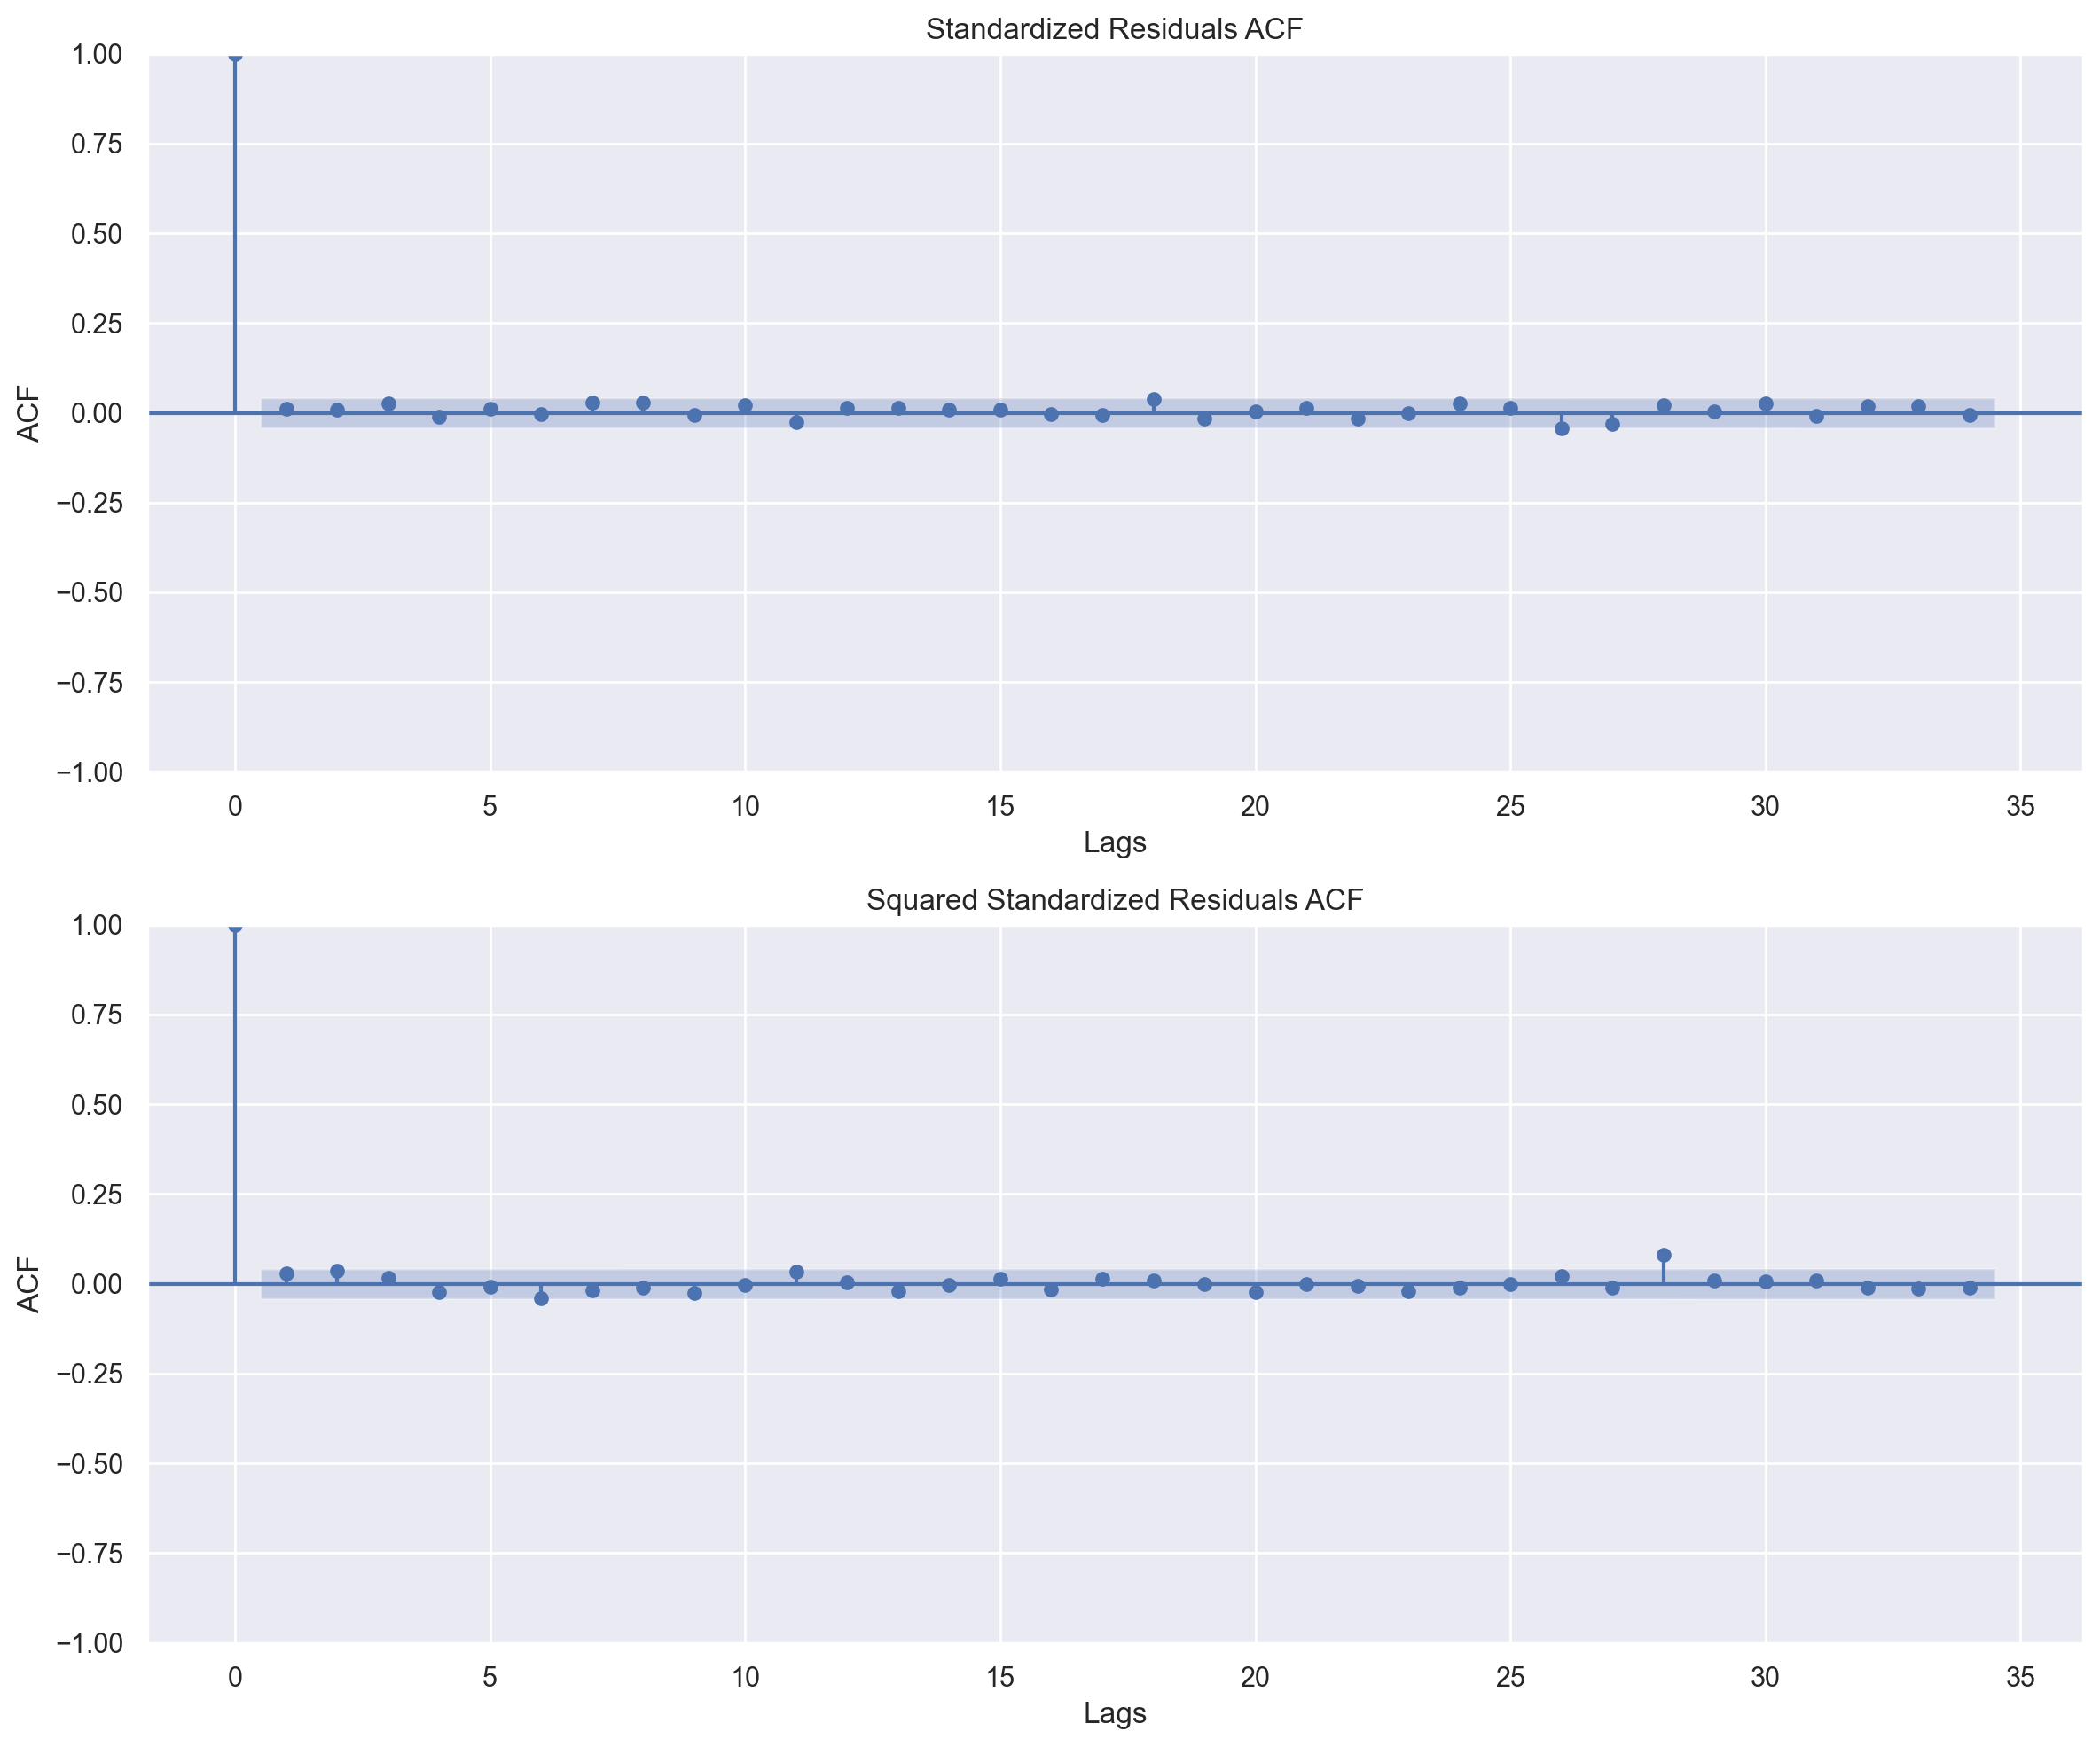

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

sm.graphics.tsa.plot_acf(standardized_resid, ax=ax[0])
sm.graphics.tsa.plot_acf(standardized_resid**2, ax=ax[1])
ax[0].set_title("Standardized Residuals ACF")
ax[0].set_xlabel("Lags")
ax[0].set_ylabel("ACF")
ax[1].set_title("Squared Standardized Residuals ACF")
ax[1].set_xlabel("Lags")
ax[1].set_ylabel("ACF")
plt.tight_layout()

plt.show()

residuals and squared residuals: non serially correlated -> consistent with independance assumption.

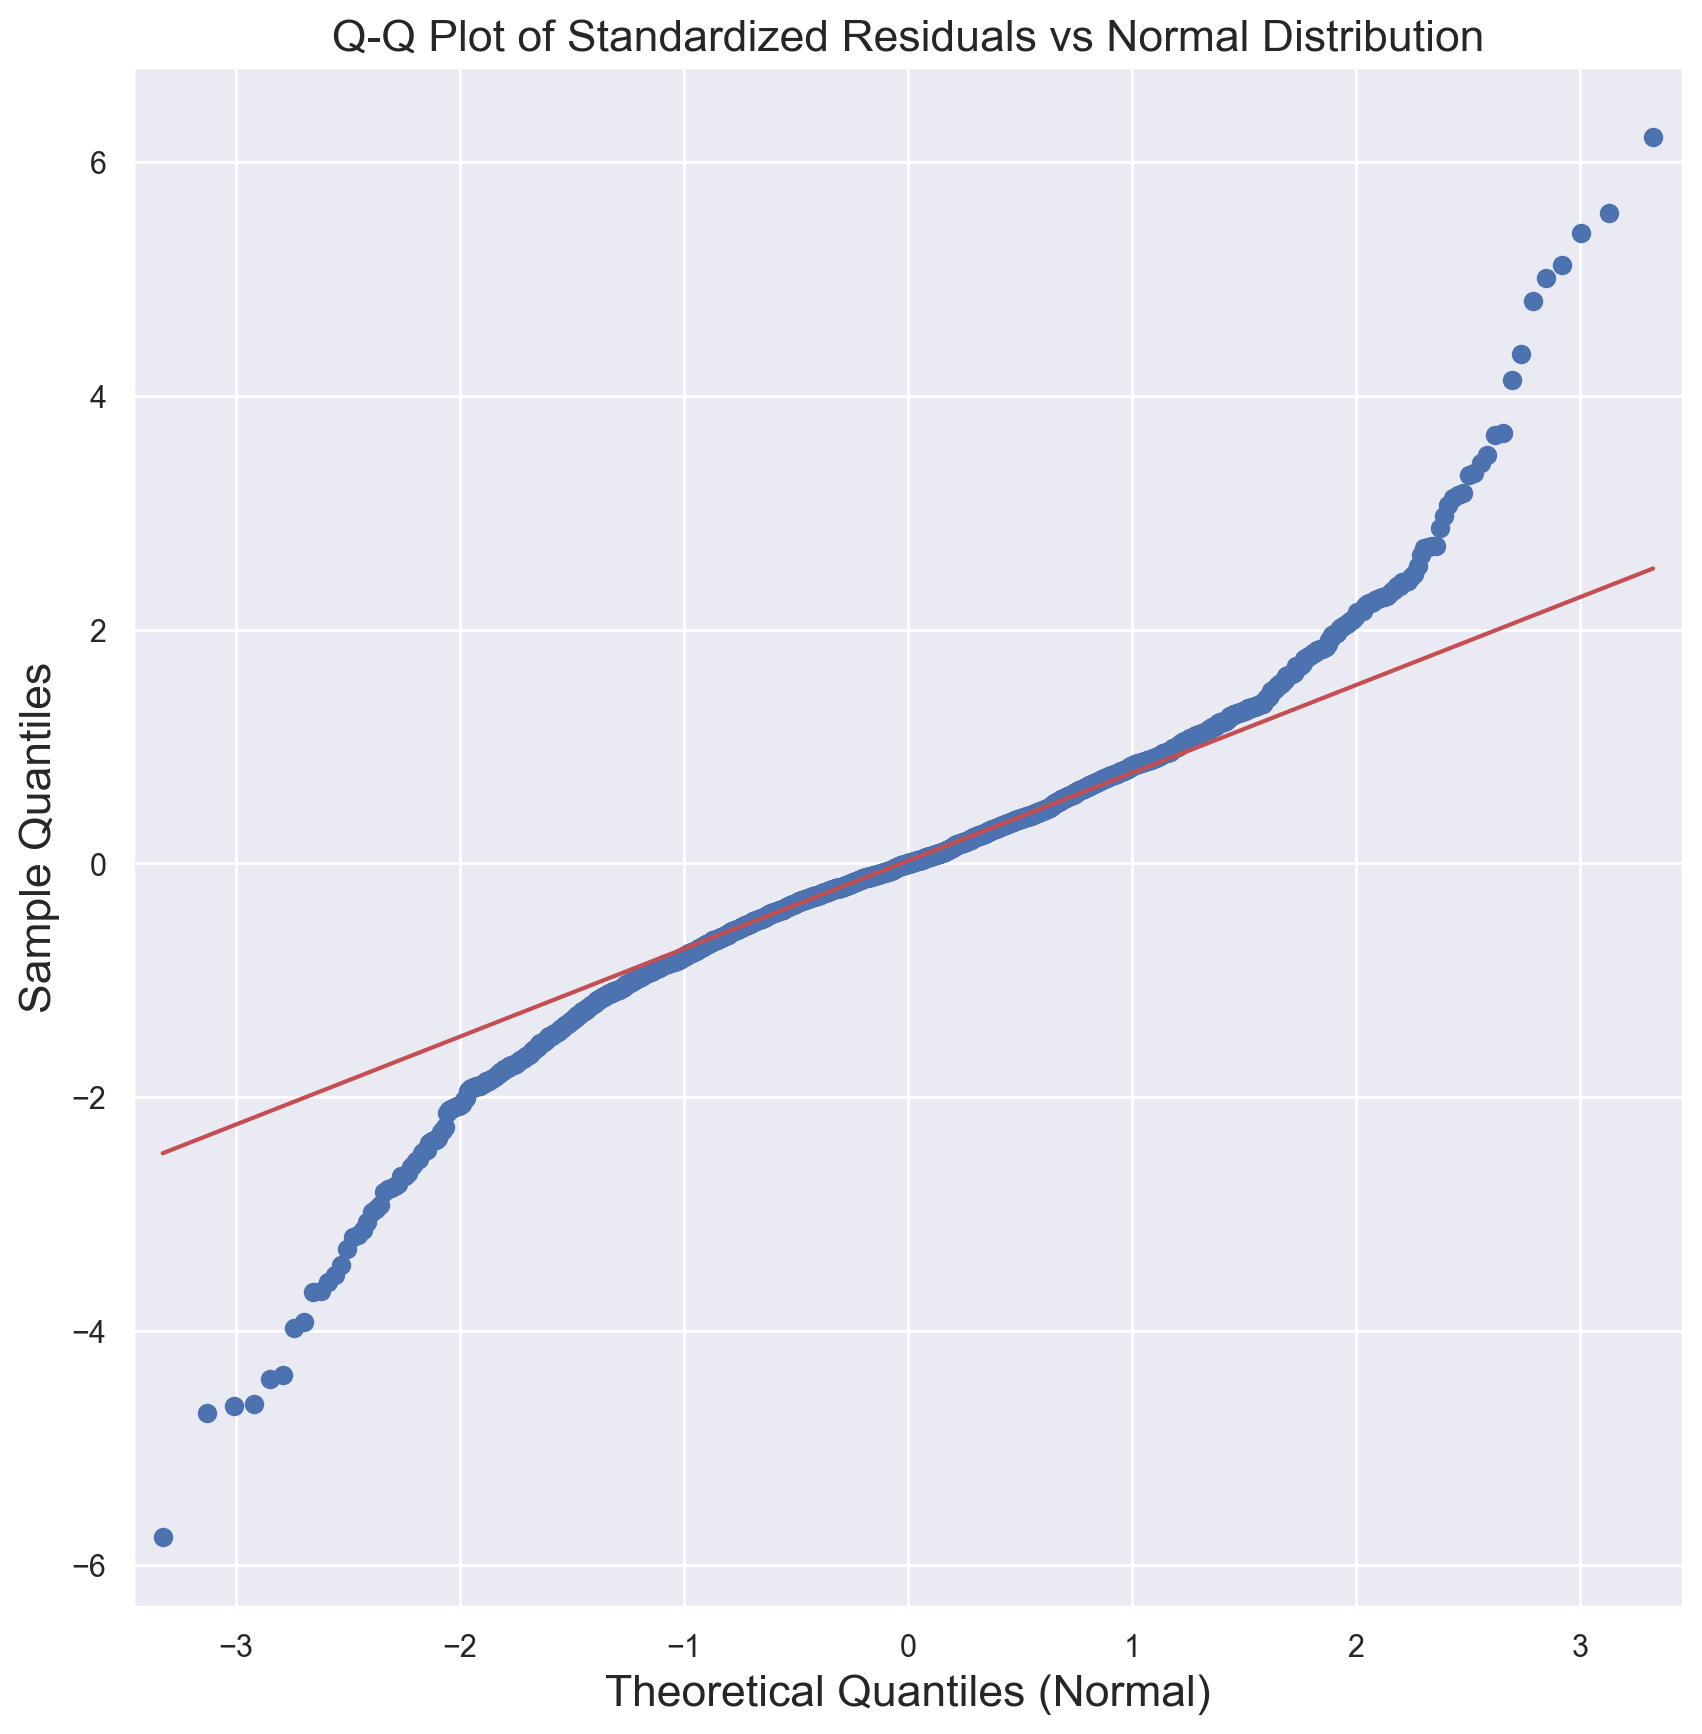

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
sm.qqplot(standardized_resid, dist=stats.norm, ax=ax, line='q')
plt.xlabel('Theoretical Quantiles (Normal)', fontsize=16)
plt.ylabel('Sample Quantiles', fontsize=16)
plt.title('Q-Q Plot of Standardized Residuals vs Normal Distribution', fontsize=16)
plt.show()

Tails seem heavier on the observed residuals distribution than on the theoretical normal distribution. 

In [13]:
df_estimate, loc_estim, scale_estim = stats.t.fit(standardized_resid)

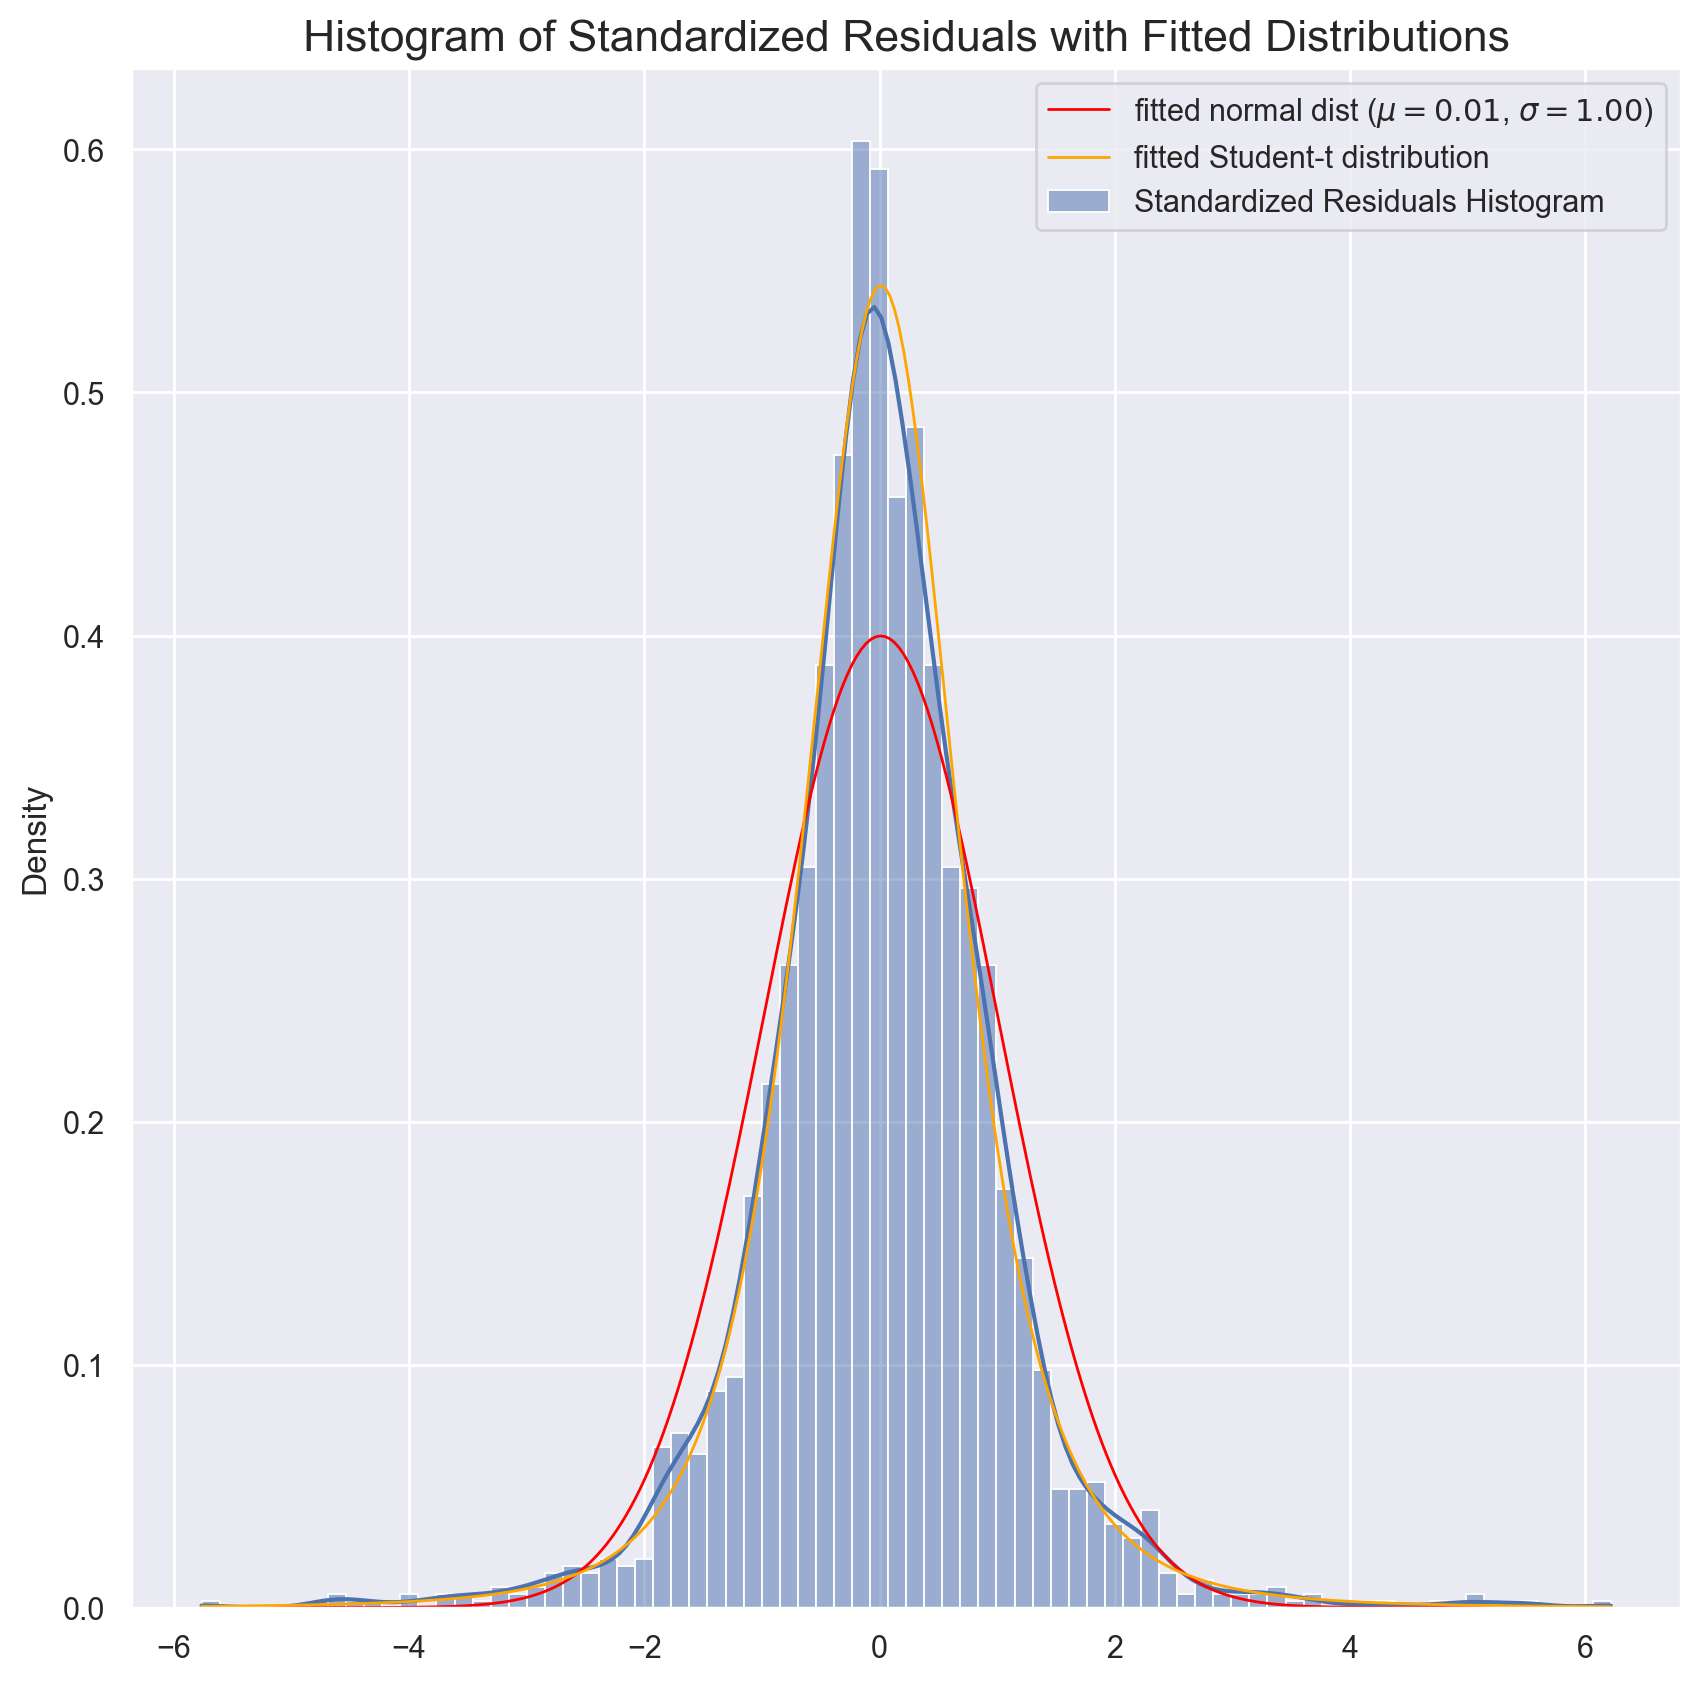

In [14]:
from scipy.stats import norm, t
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot(standardized_resid, kde=True, ax=ax, stat='density', label='Standardized Residuals Histogram')
mean, std = np.mean(standardized_resid), np.std(standardized_resid)
xs = np.linspace(min(standardized_resid), max(standardized_resid), 300)
ax.plot(xs, norm.pdf(xs, mean, std), label=f"fitted normal dist ($\mu={mean:.2f}$, $\sigma={std:.2f}$)", linewidth=1, color='red')
ax.plot(xs, t.pdf(xs, df_estimate, loc_estim, scale_estim), label=f"fitted Student-t distribution", linewidth=1, color='orange')
ax.set_title("Histogram of Standardized Residuals with Fitted Distributions", fontsize=16)
ax.legend()

plt.show()

The student-t distribution seems to be a better fit. 

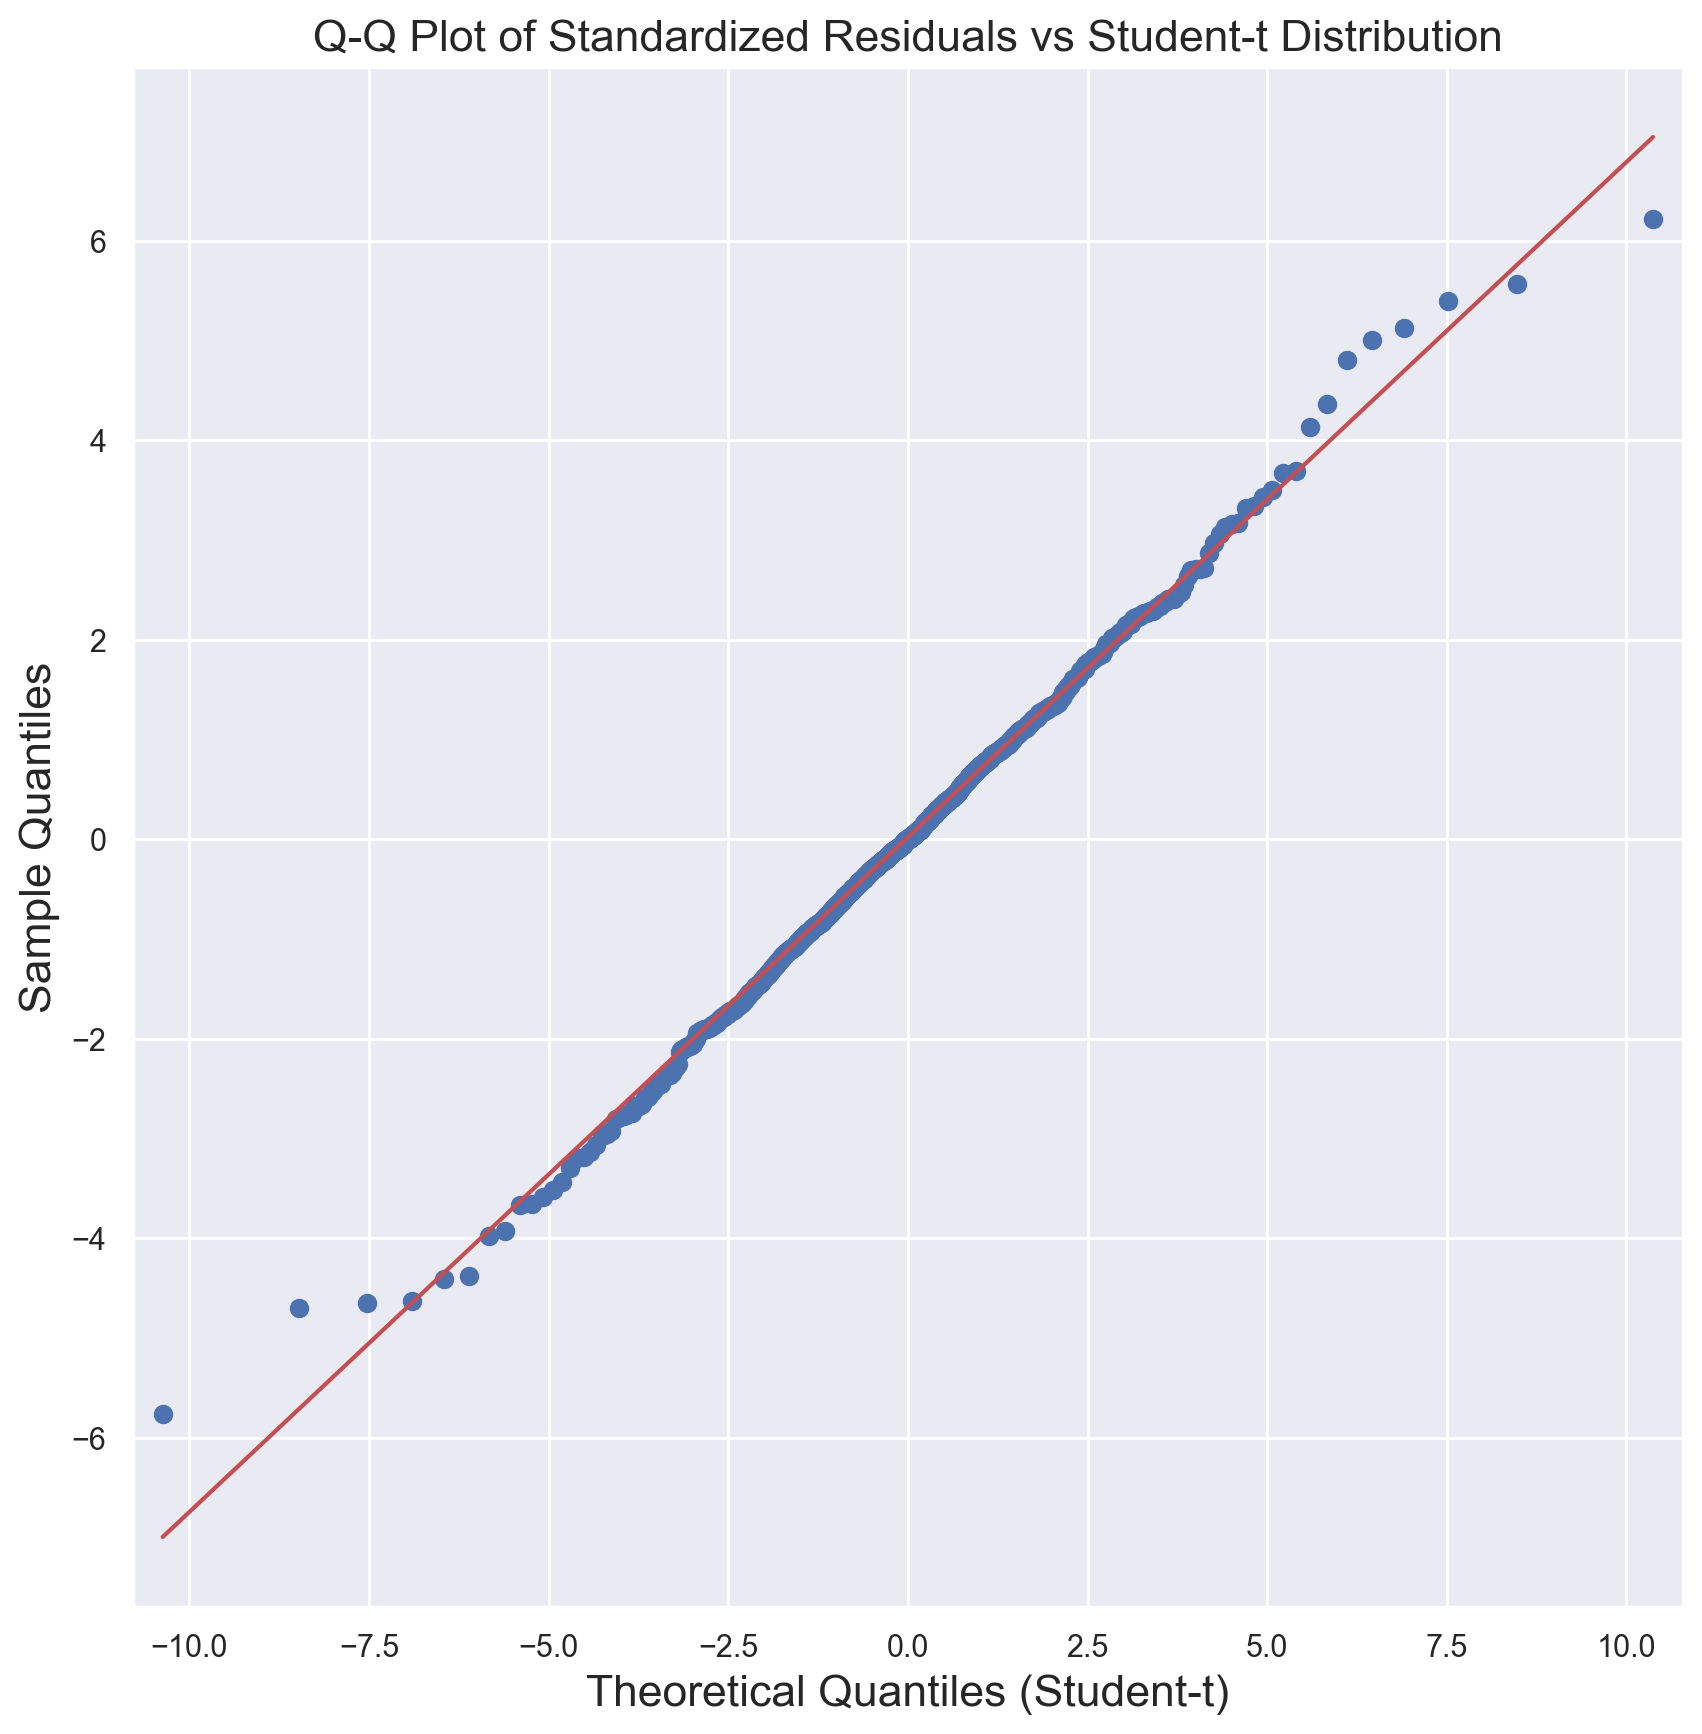

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
sm.qqplot(standardized_resid, dist=stats.t, distargs=(df_estimate,), ax=ax, line='q')
plt.xlabel('Theoretical Quantiles (Student-t)', fontsize=16)
plt.ylabel('Sample Quantiles', fontsize=16)
plt.title('Q-Q Plot of Standardized Residuals vs Student-t Distribution', fontsize=16)
plt.show()

The standard residuals seem to be drawn from a Student-t distribution. Thus, the assumption of the residuals being identically-distributed seems fair. 

In [16]:
train_df.loss.sum()

np.float64(5.152806204254169)

In [17]:
thresholds = np.linspace(0, 0.5, 100)
x = []
excess_means = []
for thresh in thresholds:
    excess_df = train_df.loc[train_df['loss']>thresh,'loss']
    nb_excess = excess_df.count()
    excess_mean = excess_df.sum()/nb_excess if nb_excess>0 else None
    if len(excess_means)>0 and excess_mean!=excess_means[-1]:
        excess_means.append(excess_mean)
        x.append(thresh)
    elif len(excess_means)==0:
        excess_means.append(excess_mean)
        x.append(thresh)


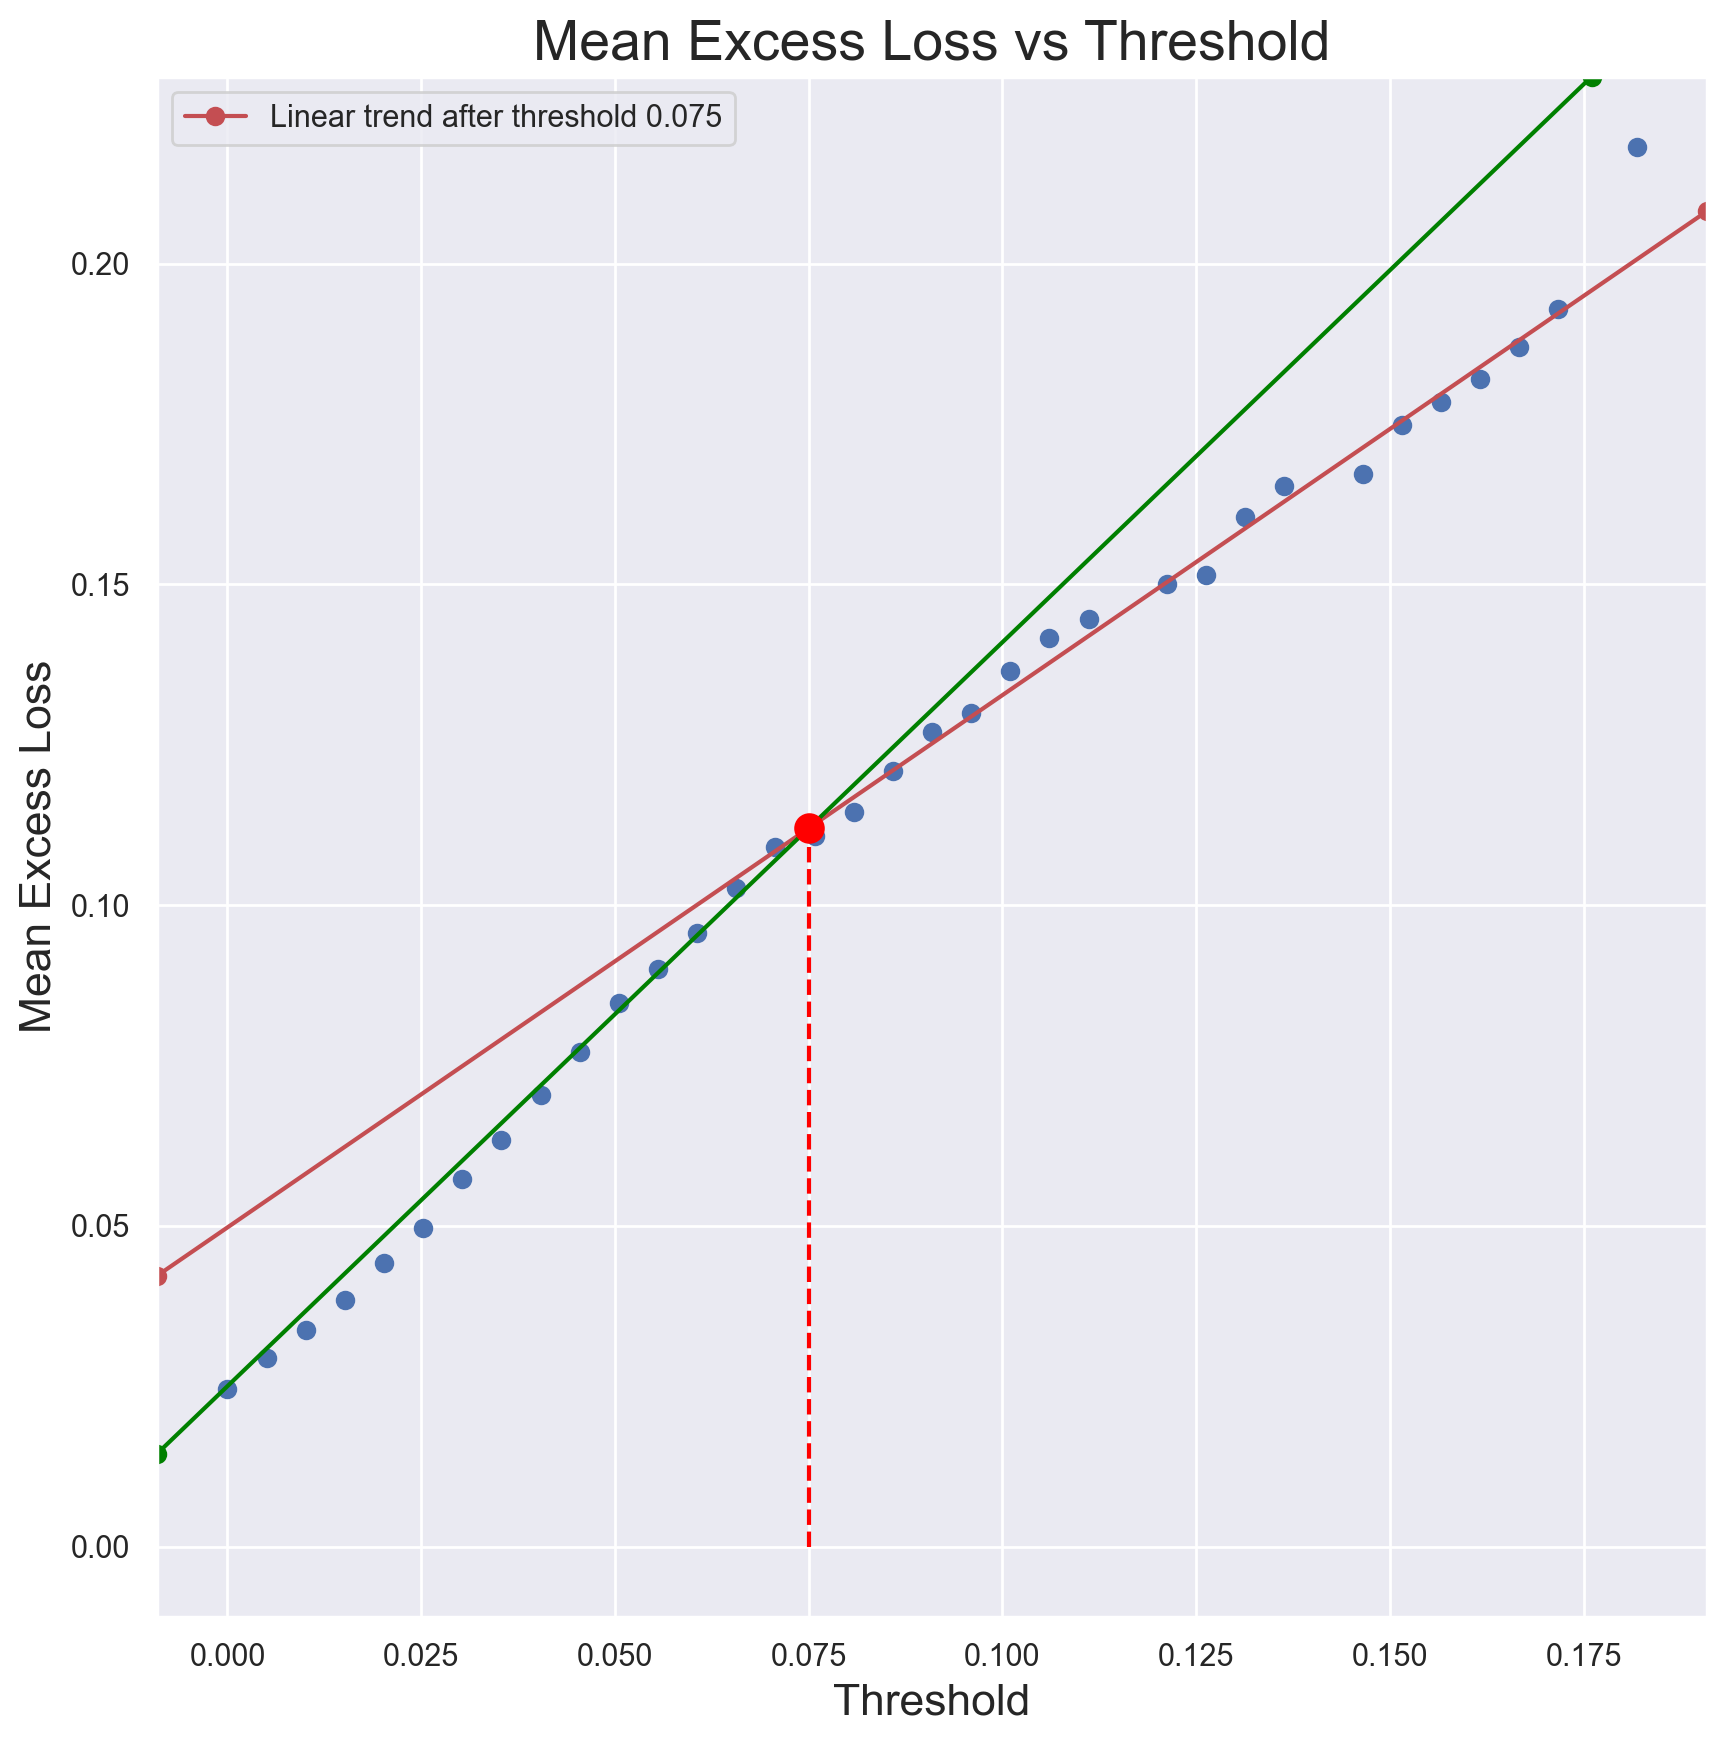

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x, excess_means)
plt.axline((0.075, 0.112), (0.175, 0.195), marker = 'o', color='r', label='Linear trend after threshold 0.075')
plt.axline((0.075, 0.112), (0, 0.025), marker = 'o', color='green')
plt.scatter(0.075, 0.112, color='red', s=100, zorder=5)
plt.plot([0.075, 0.075], [0, 0.112], linestyle='--', color='red')
plt.legend()
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Mean Excess Loss', fontsize=16)
plt.title('Mean Excess Loss vs Threshold', fontsize=20)
plt.show()

There seems to be two linear tendencies on the mean excess plot. We want to have a linear trend after a certain threshold u. This threshold is set at u=0.075, as we can see on the graph above. 

In [20]:
u = 0.075
excess_df = train_df.loc[train_df['loss']>u,'loss'] - u

In [21]:
from scipy.stats import genpareto
params = genpareto.fit(excess_df, floc=0)

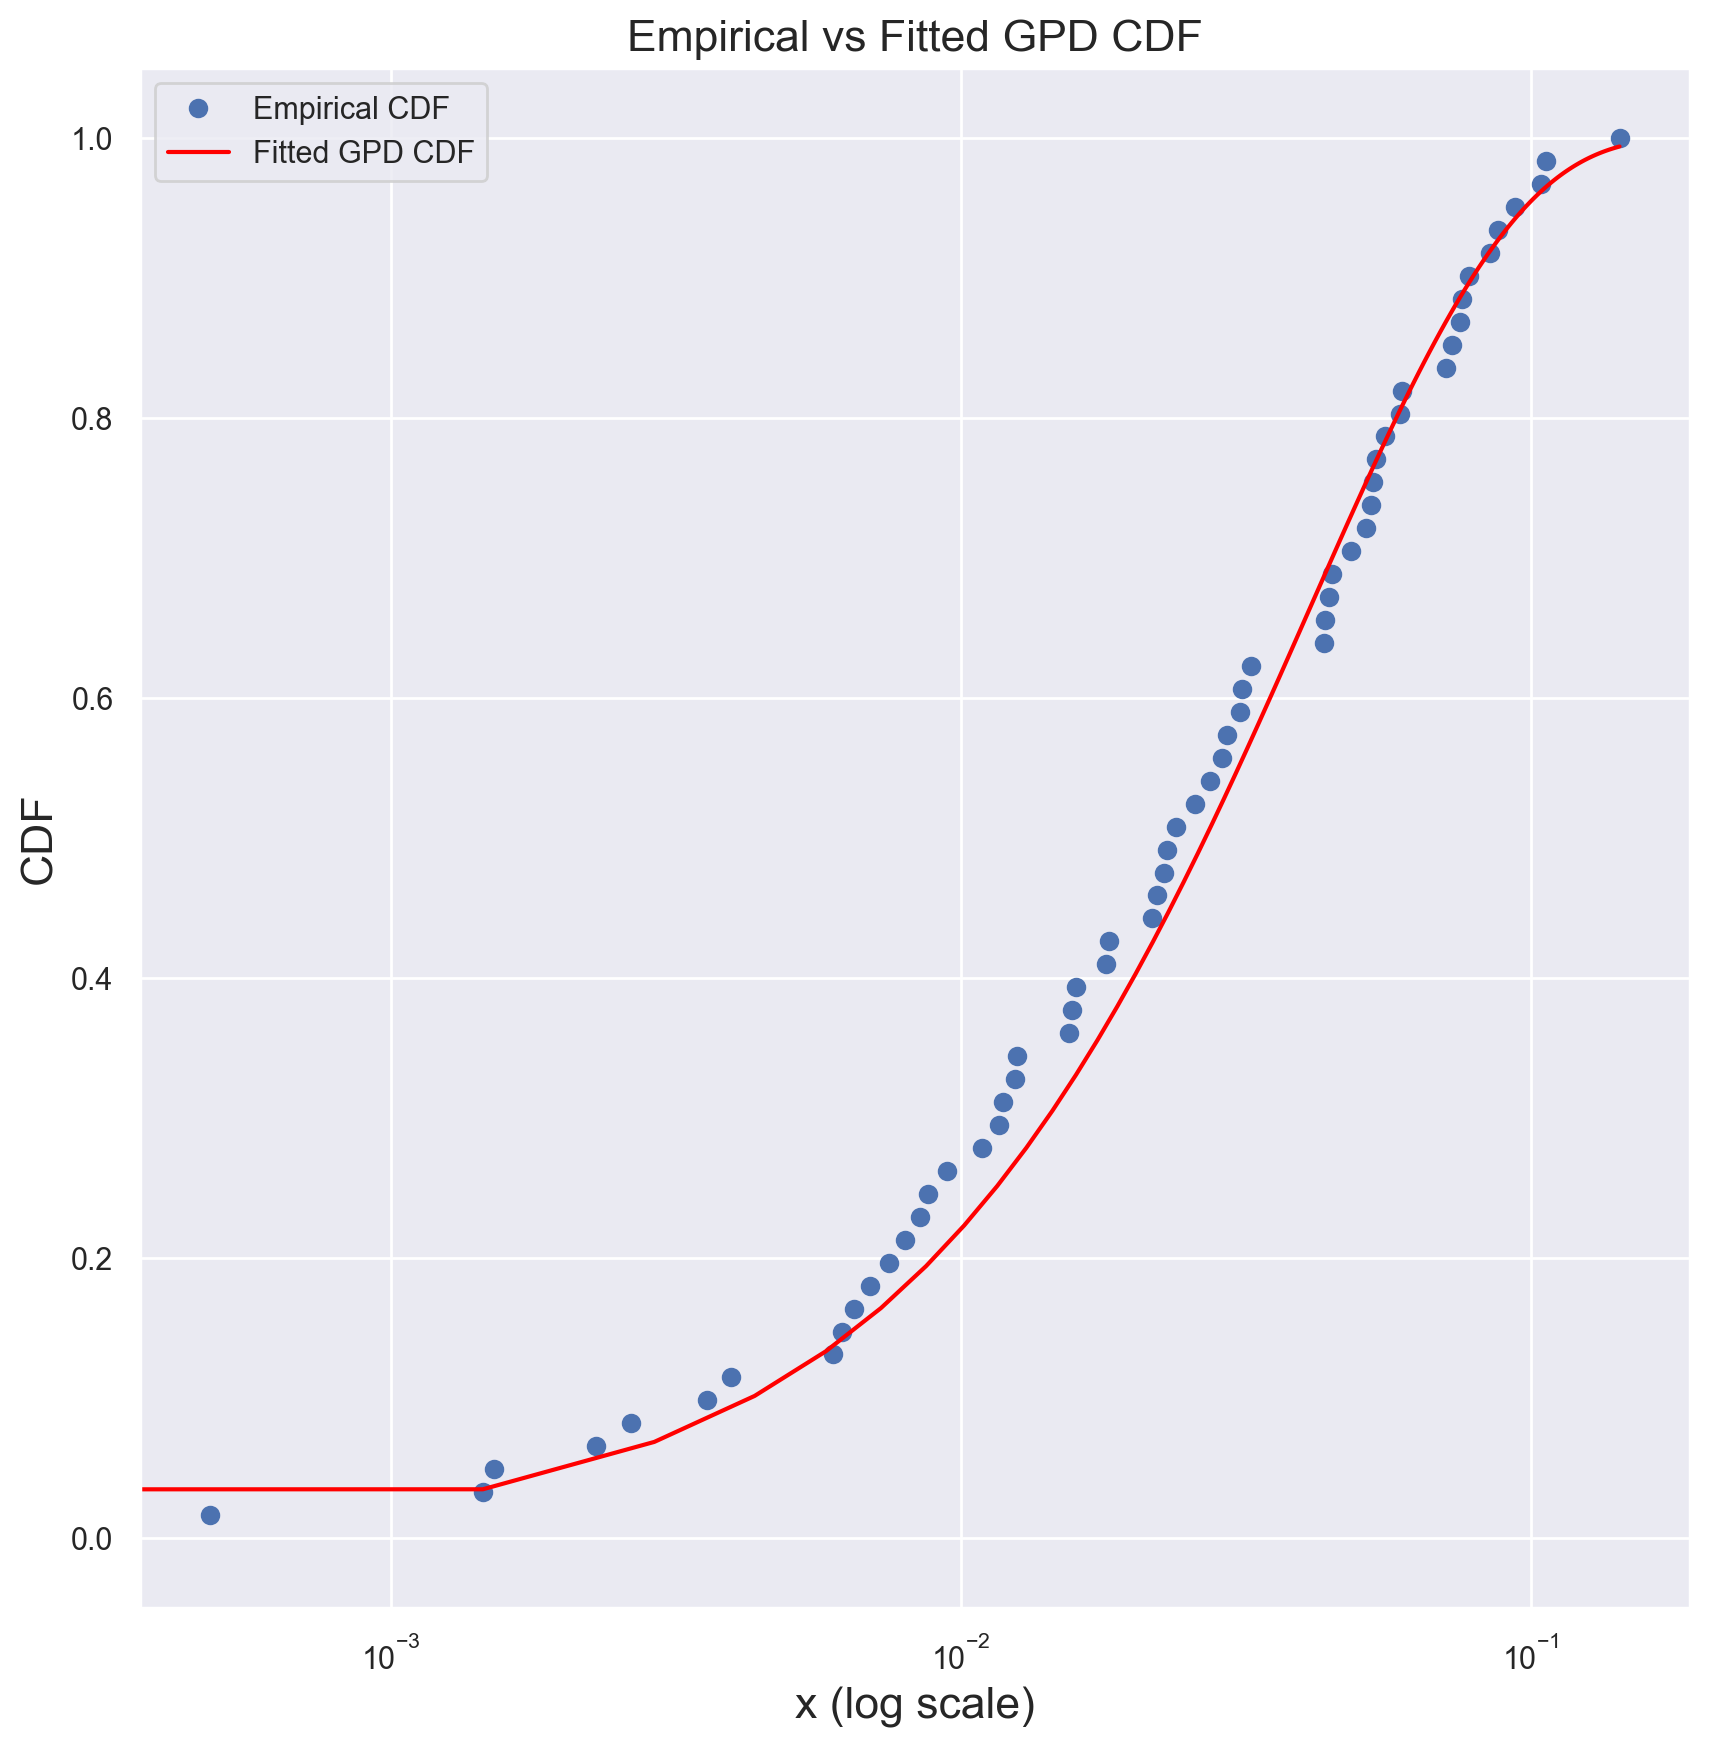

In [22]:
sorted = excess_df.sort_values().reset_index(drop=True)
cdf_values = []
for i in range(len(excess_df)):
        cdf_value = np.sum(sorted <= sorted[i]) / len(excess_df)
        cdf_values.append(cdf_value)


plt.figure(figsize=(10, 10))
plt.plot(np.sort(excess_df), cdf_values, marker='o', linestyle='', label='Empirical CDF')
x = np.linspace(0, max(excess_df), 100)
plt.plot(x, genpareto.cdf(x, params[0], params[1], params[2]), label='Fitted GPD CDF', color='red')
plt.legend()
plt.gca().set_xscale('log', base=10)
plt.title("Empirical vs Fitted GPD CDF", fontsize=16)
plt.xlabel("x (log scale)", fontsize=16)
plt.ylabel("CDF", fontsize=16)
plt.show()

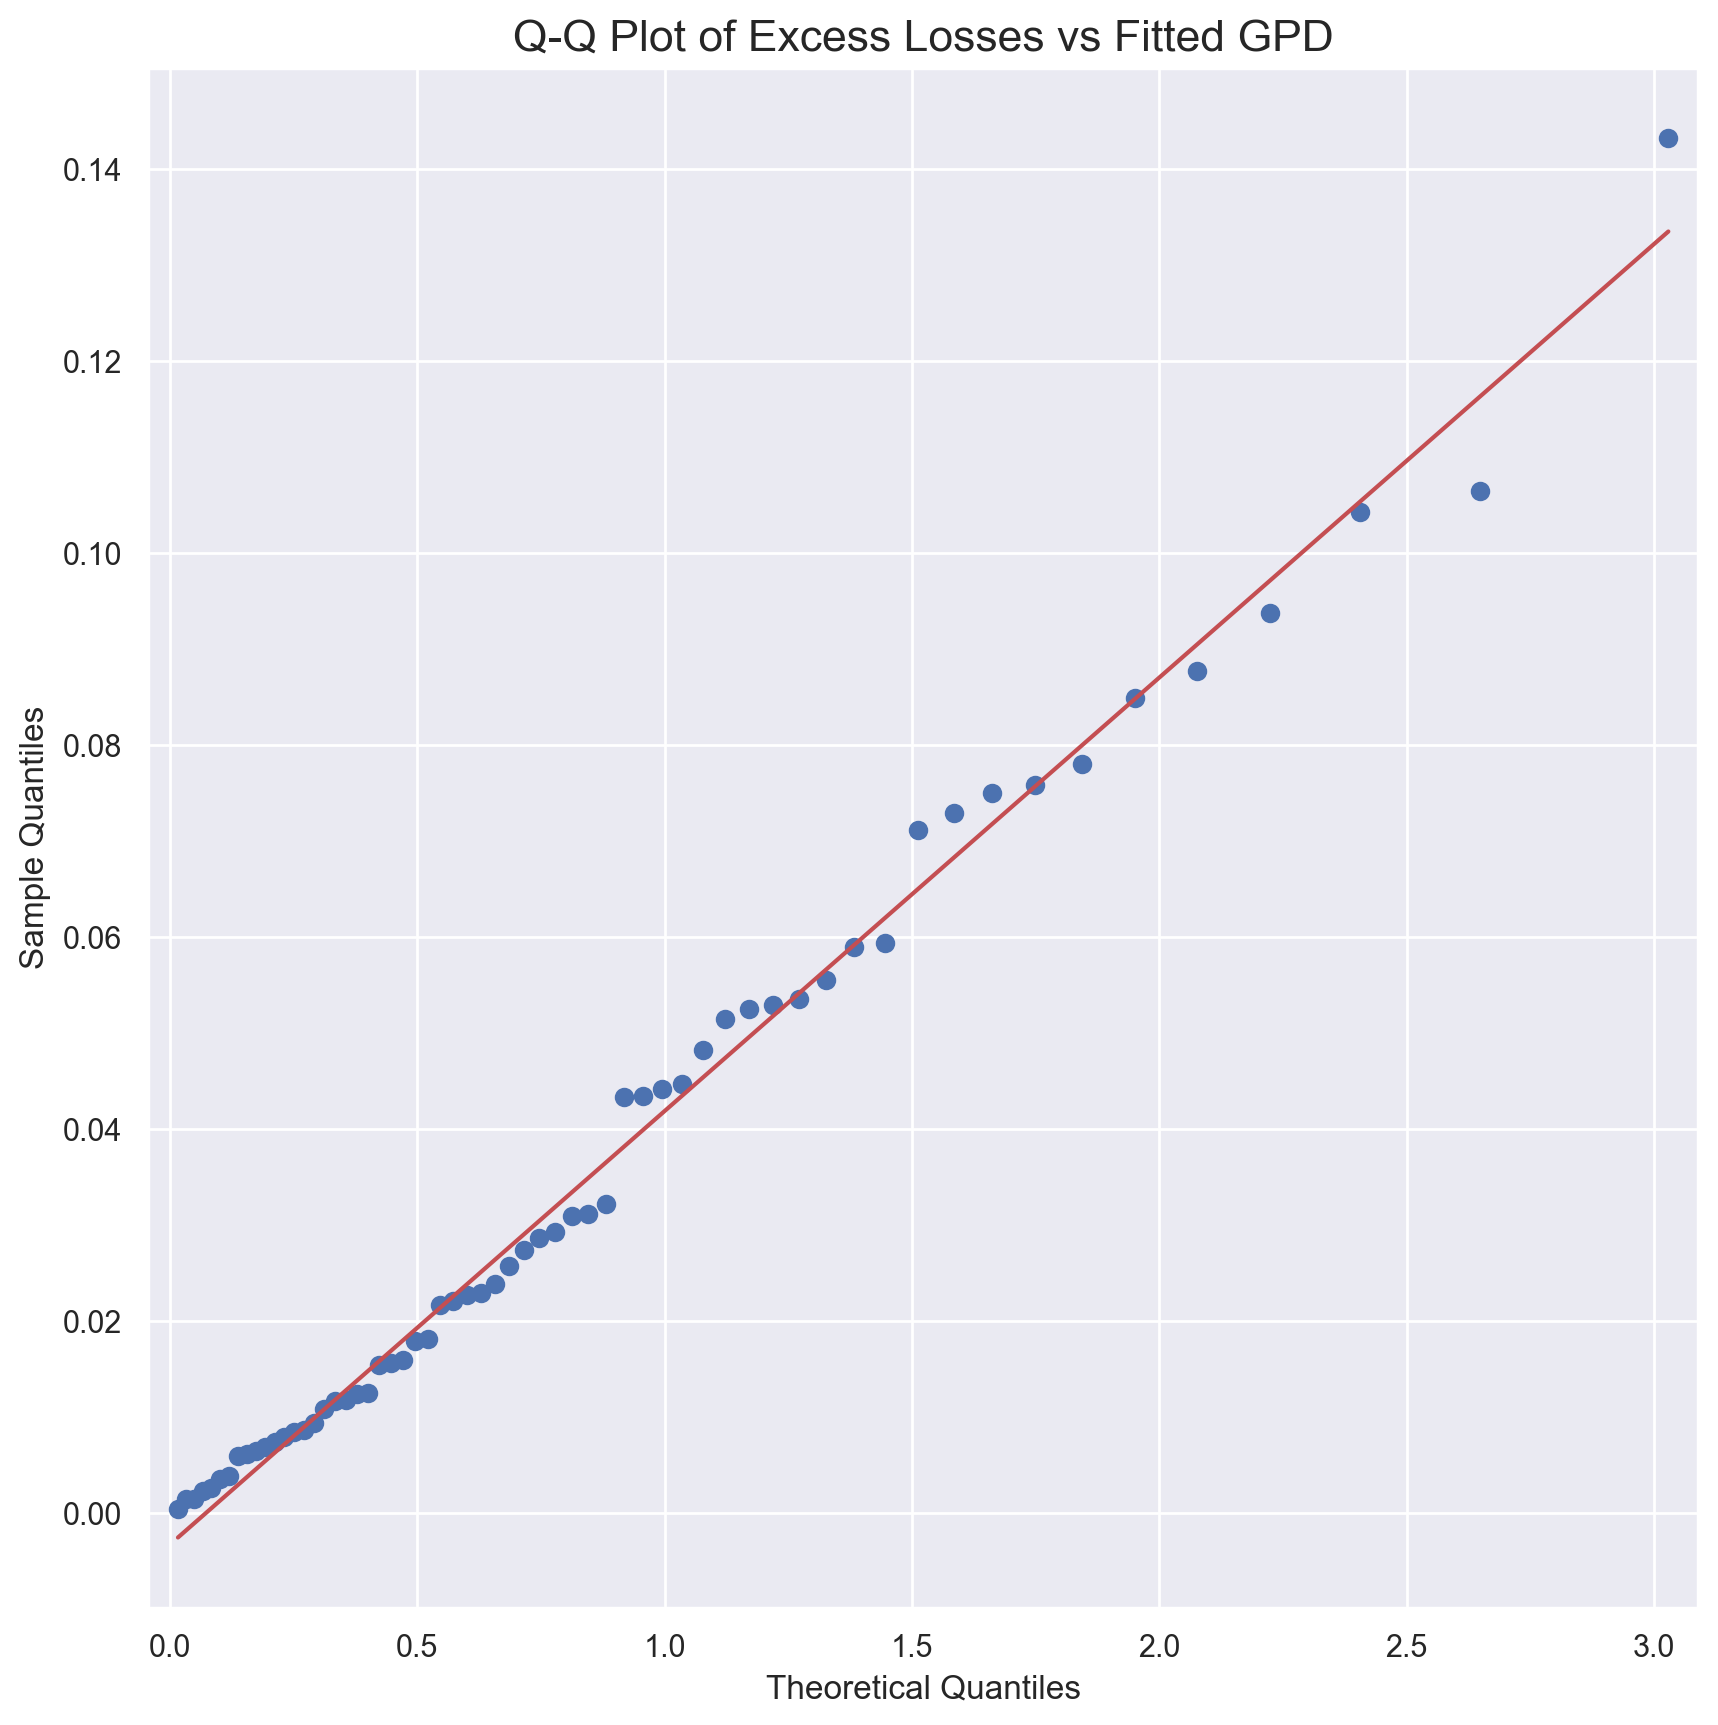

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
sm.qqplot(excess_df, dist=genpareto, distargs=(params[0],), ax=ax, line='q')
plt.title('Q-Q Plot of Excess Losses vs Fitted GPD', fontsize=16)
plt.show()

In [24]:
from scipy.stats import kstest
ks_statistic, p_value = kstest(excess_df, 'genpareto', args=params)
alpha = 0.05
if p_value < alpha:
    print(f"The p-value ({p_value:.4f}) is less than {alpha}, so we reject the null hypothesis.")
    print("The data does not appear to follow a Generalized Pareto Distribution with the estimated parameters.")
else:
    print(f"The p-value ({p_value:.4f}) is greater than {alpha}, so we fail to reject the null hypothesis.")
    print("The data appears to follow a Generalized Pareto Distribution with the estimated parameters.")

The p-value (0.8588) is greater than 0.05, so we fail to reject the null hypothesis.
The data appears to follow a Generalized Pareto Distribution with the estimated parameters.


## VaR with GARCH(1,1) and normal innovations

Fitting the model on train data

In [61]:
Garch_normal = arch_model(train_df.loss, p=1, q=1, vol='GARCH', mean='constant', dist='normal')
res = Garch_normal.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1079304055.5770965
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2411264586.2126827
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4578.601622614128
            Iterations: 2
            Function evaluations: 26
            Gradient evaluations: 2


c:\Users\ilias\anaconda3\envs\qrm\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001215. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


In [117]:
res

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   loss   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4578.60
Distribution:                  Normal   AIC:                          -9149.20
Method:            Maximum Likelihood   BIC:                          -9126.30
                                        No. Observations:                 2266
Date:                Mon, Dec 01 2025   Df Residuals:                     2265
Time:                        17:43:32   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.5960e-03  6.420e-04      2.486  1.292e-02 [3.

In [108]:
preds = res.forecast(horizon=len(test_df))
mus = preds.mean.squeeze()
sigmas = np.sqrt(preds._residual_variance.squeeze())

In [ ]:
quantile99 = res.std_resid.quantile(0.99)
quantile95 = res.std_resid.quantile(0.95)
stats.norm.ppf(0.95)

In [110]:
mus.index = test_df.Date
sigmas.index = test_df.Date

In [123]:
stats.norm.ppf(0.95)

np.float64(1.6448536269514722)

In [166]:
test_df['mus'], test_df['sigmas'] = mus.values, sigmas.values
test_df['VaR95'] = test_df['mus'] + test_df['sigmas']*stats.norm.ppf(0.95)
test_df

,Date,TSLA,log_returns,loss,mus,sigmas,VaR95
2268,2021-11-29,378.996674,-0.049647,0.049647,0.001596,0.037871,0.063888
2269,2021-11-30,381.586670,-0.006811,0.006811,0.001596,0.037813,0.063793
2270,2021-12-01,365.000000,0.044441,-0.044441,0.001596,0.037756,0.063700
2271,2021-12-02,361.533325,0.009543,-0.009543,0.001596,0.037701,0.063608
2272,2021-12-03,338.323334,0.066352,-0.066352,0.001596,0.037646,0.063518
...,...,...,...,...,...,...,...
2514,2022-11-18,180.190002,0.016403,-0.016403,0.001596,0.034881,0.058970
2515,2022-11-21,167.869995,0.070822,-0.070822,0.001596,0.034880,0.058969
2516,2022-11-22,169.910004,-0.012079,0.012079,0.001596,0.034880,0.058968
2517,2022-11-23,183.199997,-0.075310,0.075310,0.001596,0.034879,0.058968


In [165]:
VaR

[np.float64(0.31464666702900335),
 np.float64(0.3151404379332021),
 np.float64(0.31464783188626644),
 np.float64(0.315099545812857),
 np.float64(0.3146687648321922),
 np.float64(0.3156379375662627),
 np.float64(0.3146540627128307),
 np.float64(0.3149855720429543),
 np.float64(0.31468822959825377),
 np.float64(0.3155392627918544),
 np.float64(0.3146705194286566),
 np.float64(0.3152403183760168),
 np.float64(0.31466272445886),
 np.float64(0.31470060666065364),
 np.float64(0.31525244343691977),
 np.float64(0.3146462950366275),
 np.float64(0.31494100775260037),
 np.float64(0.31499425000407216),
 np.float64(0.31571935566173237),
 np.float64(0.31528128617237455),
 np.float64(0.3147596270387249),
 np.float64(0.3146513933911997),
 np.float64(0.3146449031841928),
 np.float64(0.31469932797910344),
 np.float64(0.3146864198986245),
 np.float64(0.3180168662276166),
 np.float64(0.315066248586067),
 np.float64(0.31533214998732795),
 np.float64(0.31475978229255935),
 np.float64(0.31494867088009415),
 

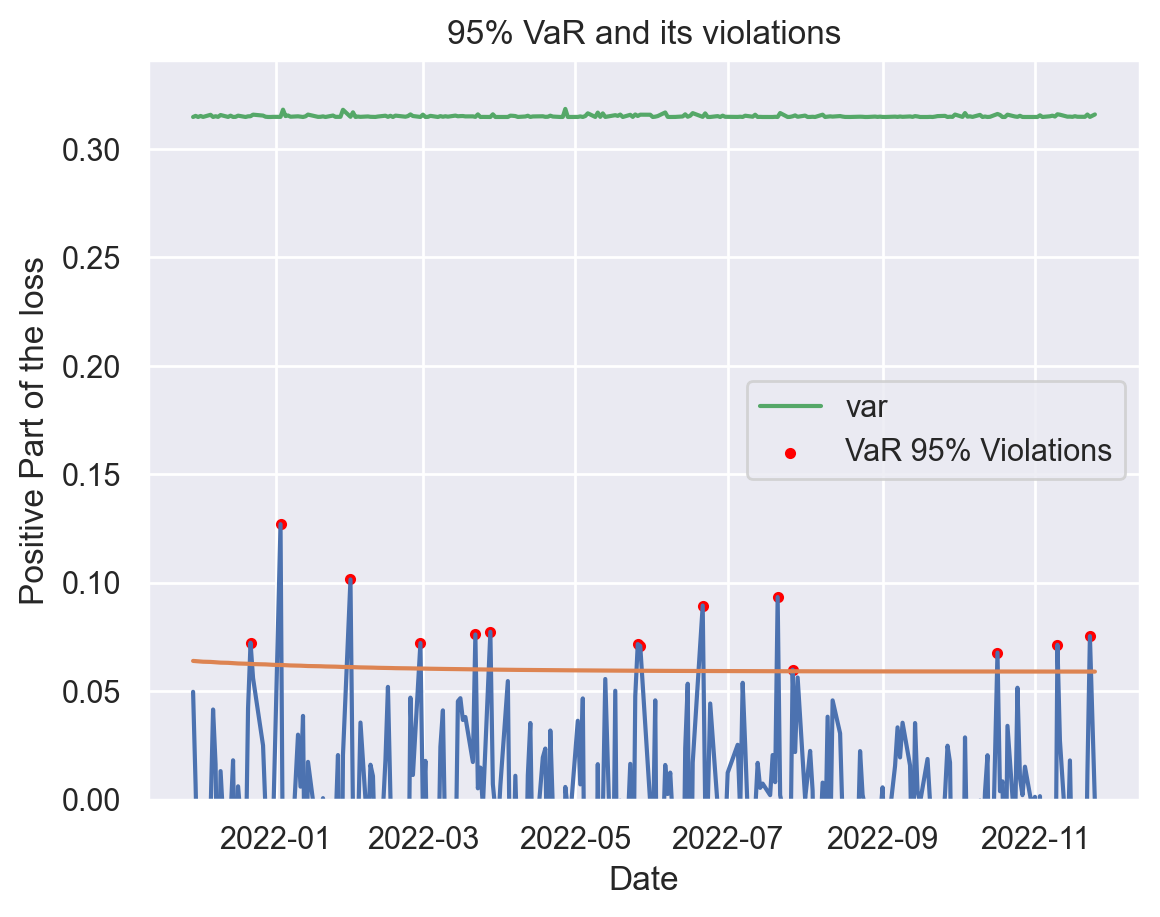

In [168]:
plt.plot(test_df.Date, test_df['loss'])
plt.plot(test_df.Date, test_df['VaR95'])
plt.plot(test_df.Date, VaR, label='var')
plt.ylim(0)
plt.ylabel('Positive Part of the loss')
plt.xlabel('Date')
locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)

violations = test_df[test_df['loss'] > test_df['VaR95']]
plt.scatter(violations.Date, violations.loss, color='red', marker='.', label='VaR 95% Violations')
plt.legend()
plt.title('95% VaR and its violations')
plt.show()


In [153]:
res.params.loc['alpha[1]']

np.float64(0.04999997842841894)

In [158]:
res.std_resid.iloc[-1]

np.float64(0.11996363791237596)

In [162]:
test_df.iloc[0, 3]

np.float64(0.04964715687419119)

In [164]:
sig = []
eps_hist = res.resid.iloc[-1]
last_sig = res.conditional_volatility.iloc[-1]
mu = res.params.mu
VaR = []
for i in range(len(test_df)):
        # use eps_hist[i] and h[i] to forecast h_{t+1}
        h_next = res.params.omega + res.params.loc['alpha[1]'] * (eps_hist**2) + res.params.loc['beta[1]'] * last_sig
        sig.append(h_next)

        # Normal VaR / ES
        VaR.append(mu + np.sqrt(h_next) *stats.norm.ppf(0.95))
        eps_next = test_df.iloc[i, 3] - mu
        eps_hist = eps_next